# Mount Google Drive to access files

---
# Imports & Config  

## Notebook Loader

In [0]:
base_dir = "gdrive/My Drive/Masterarbeit"

classes_dict_file = base_dir + "/classes.pkl"

class FLAGS_IC:

  # directories & files for tmp storage
  image_classification_dir = base_dir + "/ImageClassification"
  image_dir = base_dir + "/ImageClassification/ImagePatches"
  bottleneck_dir = base_dir + "/ImageClassification/BottleneckFeatures"
  intermediate_output_graphs_dir = base_dir + "/ImageClassification/IntermediateGraphs"
  output_graph = base_dir + "/ImageClassification/output_graph.pb"
  saved_model_dir_base = base_dir + "/ImageClassification/ExportedGraphs"
  saved_model_dir = saved_model_dir_base + "/zzz"
  summaries_base_dir = base_dir + "/ImageClassification/Summaries"
  summaries_dir = summaries_base_dir + "/zzz"
  output_labels = base_dir + "/ImageClassification/output_labels.txt"
  scores_dir = base_dir + "/ImageClassification/Scores"
  missclassified_dir = base_dir + "/ImageClassification/Missclassified"
  subfolder = "FeatureVector"
  
  #objects pickle
  objects_dict_file = base_dir + "/objects.pkl"

  # folders to include
  folders = ["_Automat"]
  
  
  # class level
  class_level = [0,1] 


  # dataset splits
  use_prob_set_assignment =  True
  max_train_images = 1000
  validation_percentage = 20
  testing_percentage = 20
  # #2
  max_num_samples_per_class = 120
  min_num_samples_per_class = 120
  validation_n = 20 
  testing_n = 20
  
  early_stopping = True

  #k_fold
  k = 5
  num_per_fold = 20

  # ...
  eval_step_interval = 10
  intermediate_store_frequency = 100

  # Hyperparameter
  learning_rate = 0.0003
  how_many_training_steps = 400

  #regularization
  regularization_rate = 0.003
  
  # batch sizes
  train_batch_size = 100
  validation_batch_size = 200
  test_batch_size = -1

  # output
  print_misclassified_test_images = True
  final_tensor_name = "final_result"

  # random permutations
  flip_left_right = False
  random_crop = 0
  random_scale = 0
  random_brightness = 0

  #classification module
  tfhub_module = 'https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/2'
  #'https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1'
  
  #retrain layers
  cf_layer = 'softmax' #'sigmoid'
  bottleneck_layer = False
  
  #initialization
  initializer = 'xavier' #'normal', 'xavier'
  
  #optimizer
  optimizer = 'adam' #'adam', 'sgd'

class FLAGS_OD:
  image_dir = base_dir + "/ObjectDetection/Images"
  
  #images pickle
  images_dict_file = base_dir + "/images.pkl"
  
class FLAGS_TB:
  # a temporary folder to run tensorboard on, doesn't seem to run on a Gdrive mounted folder
  tmp_graph_dir = "/content/summaries"
  
  # how many images fit horizontally in an image mosaic
  tb_mosaic_width = 5

## Imports

## Connect to GPU

In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Mount GDrive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Create Dataset

In [0]:
import os
import tensorflow as tf

def get_xml_files(root_dir, selected_folders=None):
  """Gets all xml files recursively inside the root directory
  and returns the file names with the path
  Args:
    root_dir: root directory as string
    selected_folders: list of folder names which should only be
        used for the dataset. If None will use all.
  Returns:
    list of tuples with file_name and path_name relative from
        root_dir
  """
  file_list = []
  
  root_f = root_dir.split(os.sep)
  for path, _, files in tf.gfile.Walk(root_dir):
    path_f = path.split(os.sep)
    if not selected_folders is None and not \
        any(s_folder in path_f for s_folder in selected_folders):
      continue
    for file in files:
      if file.split(".")[-1] == "xml":
        rel_path = [f for f in path_f if f not in root_f]
        rel_path = os.path.join(*rel_path)
        file_list.append((file, rel_path))
  
  return file_list
  

In [0]:
import os
from bs4 import BeautifulSoup

def load_annotation(file_path, infos, use_gtin=False):
  """
  Load annotation file for a given image and parse xml to dict.
  Args:
    img_name: string of the image name.
    infos: dict with information that should be appended to image dict
  Returns:
    dict of the image with all infos
  """
  xml = ""
  with open(file_path, 'r') as f:
    xml = f.readlines()
  xml = ''.join([line.strip('\t') for line in xml])
  bs = BeautifulSoup(xml)
  image_filename = os.path.join(*(file_path.split(os.sep)[:-1]))
  filename = bs.filename.string.replace("\n","").replace("\t","").replace(" ","")
  image_filename = os.path.join(image_filename, filename)
  image = {"filename": image_filename.replace("\n",""),
           "size": {"width": int(bs.size.width.string),
                    "height": int(bs.size.height.string)},
           "objects": []}
  for key, val in infos.items():
    image[key] = val

  for ob in bs.find_all("object"):
    name = ob.find('name').string.replace("\n","").replace("\t","").replace(" ","")
    if use_gtin:
      name_parts = name.split("_")
      if len(name_parts) == 6:
        name = "gtin" + name_parts[-1]
          
    obj = {"name": name,
           "bndbox":{"xmin": int(ob.bndbox.xmin.string),
                     "xmax": int(ob.bndbox.xmax.string),
                     "ymin": int(ob.bndbox.ymin.string),
                     "ymax": int(ob.bndbox.ymax.string)},
           "pose":ob.pose.string,
           "truncated": bool(ob.truncated.string),
           "difficult": bool(ob.difficult.string)}
    image["objects"].append(obj)
  return image

In [0]:
def get_filename_clean(filename):
  return ".".join(filename.split("/")[-1].split(".")[:-1])

def img_filesuffix(objname, filename):
  return os.path.join(FLAGS_IC.image_dir,
                      objname,
                      get_filename_clean(filename))

In [0]:
import os
import glob

def check_if_image_patches_exist(image_dict):
  """
  Check if for an image_dict the expected number of objects exist
  Args:
    image_dict: dictonary with all the image information
  Returns:
    true if correct number of image patches else false
  """
  num_objs_exist = 0
  list_of_patches = {}
  for obj in image_dict["objects"]:
    if os.path.isdir(os.path.join(FLAGS_IC.image_dir,obj["name"])):
      files = glob.glob('{}*.png'.format(img_filesuffix(obj["name"], image_dict["filename"])))
      for file in files:
        if not file in list_of_patches:
          num_objs_exist += 1
          list_of_patches[file] = [file, image_dict["filename"], obj["name"]]
  
  if num_objs_exist == len(image_dict["objects"]):
    return True, list_of_patches
  else:
    return False, list_of_patches

In [0]:
import os
import glob

def clean_for_image(image_dict):
  """
  Clean out all image patches beloging to the image_dict
  Args:
    image_dict: dictonary with all the image information  
  """
  for obj in image_dict["objects"]:
    if os.path.isdir(os.path.join(FLAGS_IC.image_dir,obj["name"])):
      files = glob.glob('{}*.png'.format(img_filesuffix(obj["name"], image_dict["filename"])))
      for file in files:
        assert (os.path.isfile(file) and FLAGS_IC.image_dir in file), "Cannot delete this something is wrong with {}".format(file)
        print("file: removing ", file)
        os.remove(file)

In [0]:
import random
import os
from PIL import Image

def extract_image_patches(image_dict):
  """
  for every patch create a new file and save it in a folder named as the object
  and the filename named after the image plus a random number to allow multi
  objects per image
  Args:
    image_dict: dictonary with all the image information
  """
  if os.path.exists(image_dict["filename"]):
    im=Image.open(image_dict["filename"])
  else:
    return
  
  list_of_patches = {}
  for obj in image_dict["objects"]:
    if not os.path.isdir(os.path.join(FLAGS_IC.image_dir,obj["name"])):
      os.mkdir(os.path.join(FLAGS_IC.image_dir,obj["name"]))
      print("dir: created ", obj["name"])
    
    bndbox = obj["bndbox"]
    bndbox = (bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"])
    
    im2=im.crop(bndbox)

    image_patch_file = img_filesuffix(obj["name"], image_dict["filename"]) + "_" + str(random.randint(0,9999999)) + ".png" 
    im2.save(image_patch_file)
    print("file: created ", image_patch_file)
    
    list_of_patches[image_patch_file] = [image_patch_file, image_dict["filename"], obj["name"]]
    
  return list_of_patches

In [0]:
files = get_xml_files(FLAGS_OD.image_dir, FLAGS_IC.folders)

image_patches = {}

for file in files:
  image_dict = load_annotation(os.path.join(FLAGS_OD.image_dir, file[1], file[0]), {})
  file_done, image_patches_per_file = check_if_image_patches_exist(image_dict)
  if not file_done:
    clean_for_image(image_dict)
    image_patches_per_file = extract_image_patches(image_dict)
  else:
    print("skipping ", image_dict["filename"])
  image_patches.update(image_patches_per_file)
    
with open(os.path.join(FLAGS_IC.image_dir,"list_of_patches.csv"), "w+") as file:
  file.write("name;filename;class_name\n")
  file.write("\n".join(['"' + "/".join(image_patch[0].split(os.sep)[-2:]) + '";"' + '";"'.join(image_patch[1:]) + '"' for image_patch in image_patches.values()]))

# Image Classification

In [0]:
# Image Recognition imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import collections
from datetime import datetime
import hashlib
import os
import os.path
import random
import re
import sys

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import seaborn as sns
from io import BytesIO

from PIL import Image, ImageFont, ImageDraw
import numpy as np

MAX_NUM_IMAGES_PER_CLASS = 1000   #2 ** 27 - 1  # ~134M

# A module is understood as instrumented for quantization with TF-Lite
# if it contains any of these ops.
FAKE_QUANT_OPS = ('FakeQuantWithMinMaxVars',
                  'FakeQuantWithMinMaxVarsPerChannel')


In [0]:
import collections
import os
import tensorflow as tf
import hashlib
MAX_NUM_IMAGES_PER_CLASS = 1000   #2 ** 27 - 1  # ~134M

def create_image_lists(image_dir, testing_percentage, validation_percentage):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Builds a list of training images from the file system.
  Analyzes the sub folders in the image directory, splits them into stable
  training, testing, and validation sets, and returns a data structure
  describing the lists of images for each label and their paths.
  Args:
    image_dir: String path to a folder containing subfolders of images.
    testing_percentage: Integer percentage of the images to reserve for tests.
    validation_percentage: Integer percentage of images reserved for validation.
  Returns:
    An OrderedDict containing an entry for each label subfolder, with images
    split into training, testing, and validation sets within each label.
    The order of items defines the class indices.
  """
  if not tf.gfile.Exists(image_dir):
    tf.logging.error("Image directory '" + image_dir + "' not found.")
    return None
  result = collections.OrderedDict()
  sub_dirs = sorted(x[0] for x in tf.gfile.Walk(image_dir))
  # The root directory comes first, so skip it.
  is_root_dir = True
  for sub_dir in sub_dirs:
    if is_root_dir:
      is_root_dir = False
      continue
    extensions = sorted(set(os.path.normcase(ext)  # Smash case on Windows.
                            for ext in ['JPEG', 'JPG', 'jpeg', 'jpg', 'PNG', 'png']))
    file_list = []
    dir_name = os.path.basename(sub_dir)
    if dir_name == image_dir:
      continue
    #tf.logging.info("Looking for images in '" + dir_name + "'")
    for extension in extensions:
      file_glob = os.path.join(image_dir, dir_name, '*.' + extension)
      file_list.extend(tf.gfile.Glob(file_glob))
    if not file_list:
      tf.logging.warning('No files found')
      continue
    if len(file_list) < 10:
      tf.logging.warning(
          'WARNING: Folder has less than 10 images, which may cause issues. skipping')
      continue
    elif len(file_list) > MAX_NUM_IMAGES_PER_CLASS:
      tf.logging.warning(
          'WARNING: Folder {} has more than {} images. Some images will '
          'never be selected.'.format(dir_name, MAX_NUM_IMAGES_PER_CLASS))
    label_name = re.sub(r'[^a-z0-9]+', ' ', dir_name.lower())
    training_images = []
    testing_images = []
    validation_images = []
    cnt_train_images = 0
    for file_name in file_list:
      base_name = os.path.basename(file_name)
      # We want to ignore anything after '_nohash_' in the file name when
      # deciding which set to put an image in, the data set creator has a way of
      # grouping photos that are close variations of each other. For example
      # this is used in the plant disease data set to group multiple pictures of
      # the same leaf.
      hash_name = re.sub(r'_nohash_.*$', '', file_name)
      # This looks a bit magical, but we need to decide whether this file should
      # go into the training, testing, or validation sets, and we want to keep
      # existing files in the same set even if more files are subsequently
      # added.
      # To do that, we need a stable way of deciding based on just the file name
      # itself, so we do a hash of that and then use that to generate a
      # probability value that we use to assign it.
      hash_name_hashed = hashlib.sha1(tf.compat.as_bytes(hash_name)).hexdigest()
      percentage_hash = ((int(hash_name_hashed, 16) %
                          (MAX_NUM_IMAGES_PER_CLASS + 1)) *
                         (100.0 / MAX_NUM_IMAGES_PER_CLASS))
      if percentage_hash < validation_percentage:
        validation_images.append(base_name)
      elif percentage_hash < (testing_percentage + validation_percentage):
        testing_images.append(base_name)
      else:
        if not FLAGS_IC.use_prob_set_assignment and cnt_train_images >= FLAGS_IC.max_train_images:
          if ((percentage_hash - (testing_percentage + validation_percentage) / 
              (1 - (testing_percentage + validation_percentage))) < validation_percentage /
              (testing_percentage + validation_percentage)):
            validation_images.append(base_name)
          else:
            testing_images.append(base_name)
        else:
          training_images.append(base_name)
          cnt_train_images += 1
    tf.logging.info("label: {}".format(label_name))
    tf.logging.info("\ttrain: {}".format(len(training_images)))
    tf.logging.info("\tvalid: {}".format(len(validation_images)))
    tf.logging.info("\ttest: {}".format(len(testing_images)))
    
    result[label_name] = {
        'dir': dir_name,
        'training': training_images,
        'testing': testing_images,
        'validation': validation_images,
    }
  return result

In [0]:
import pandas as pd

def create_image_lists_from_csv(csv_file, testing_n=None, testing_frac=None,
                                validation_n=None, validation_frac=None,
                                max_num=None, min_num=None):
  """Takes all image patches described in the csv file and randomly assigns them
  to fixed classes. if the percentages are give > 1 they are interpreted as count
  otherwise they are interpreted as percentage.
  Args:
    csv_file: the path to the csv file where all the image patches are described
    testing_percentage: the percentage or number of files that should be in the test set
    validation_percentage: the percentage or number of files that should be in the validation set
    max_num: the max number of files distributed among all sets
    min_num: the min number of files distributed among all sets
  Returns:
    saves the csv_file with the assignment per class
    returns a dict with the patches for training, testing, validation.
  
  """
  random_state = 17
  result = {}
  #name;filename;class_name;set
  df = pd.read_csv(csv_file, sep=";", quotechar='"')
  for it, obj_class in enumerate(df["class_name"].value_counts().sort_values(ascending=False).iteritems()):
    if not min_num is None and obj_class[1] < min_num:
      continue
    
    #shuffle elems
    sample_elems = df.loc[df["class_name"]==obj_class[0],"name"].sample(n=min(max_num, obj_class[1]),
                                                                        random_state=random_state)
    
    testing_images = sample_elems.sample(n=testing_n,
                                         frac=testing_frac,
                                         random_state=random_state).tolist()
    df.loc[df["name"].apply(lambda x: x in testing_images), "set"] = "testing"
    
    sample_elems = sample_elems.loc[sample_elems.apply(lambda x: not x in testing_images)]
    
    validation_images = sample_elems.sample(n=validation_n,
                                            frac=validation_frac,
                                            random_state=random_state).tolist()
    df.loc[df["name"].apply(lambda x: x in validation_images), "set"] = "validation"
    
    training_images = sample_elems.loc[sample_elems.apply(lambda x: not x in validation_images)].tolist()
    df.loc[df["name"].apply(lambda x: x in training_images), "set"] = "training"
    
    
    result[obj_class[0]] = {
        'dir': obj_class[0],
        'training': training_images,
        'testing': testing_images,
        'validation': validation_images,
    }
  
  #df.to_csv(os.path.join(FLAGS_IC.image_dir,"list_of_patches_finaltest.csv"), sep=";", quotechar='"')
            
  return result
  

In [0]:
#_ = create_image_lists_from_csv(os.path.join(FLAGS_IC.image_dir,"list_of_patches_with_set.csv"),
#                            testing_n=20, validation_n=20, max_num=120, min_num=100)

In [0]:
def read_image_lists_from_csv(csv_file):
  """This function reads the dataset from a given csv file
  """
  result = {}
  #name;filename;class_name;set
  df = pd.read_csv(csv_file, sep=";", quotechar='"')
  for it, obj_class in enumerate(df["class_name"].value_counts().sort_values(ascending=False).iteritems()):
    cl = (df["class_name"] == obj_class[0])
    if df[cl & (df["set"] == "training")]["name"].size > 0:
      result[obj_class[0]] = {
          'dir': obj_class[0],
          'training': df[cl & (df["set"] == "training")]["name"].tolist(),
          'testing': df[cl & (df["set"] == "testing")]["name"].tolist(),
          'validation': df[cl & (df["set"] == "validation")]["name"].tolist(),
      }
    
  return result
    

In [0]:
import random
import queue

class k_fold_split:
  """creates a k_fold split on the training images with num_per_batch 
  randomly sampled images per fold with k fold provide through a
  generator
  """
  def __init__(self, image_lists, k, num_per_batch=None):
    self.image_lists = image_lists
    self.n = -1
    self.k = k
    self.queues = {}
    self.num_per_batch = {}
    for key, val in self.image_lists.items():
      self.queues[key] = queue.Queue()
      random.shuffle(val["training"])
      for elem in val["training"]:
        self.queues[key].put(elem)
      
      if num_per_batch is None or num_per_batch * k > len(val["training"]):
        self.num_per_batch[key] = int(len(val["training"]) / k)
      else:
        self.num_per_batch[key] = num_per_batch
    
  def __iter__(self):
    return self
  
  def __next__(self):
    self.n += 1
    if self.n < self.k:
      result = {}
      for key, val in self.image_lists.items():    
        result[key] = {
          'dir': key,
          'training': [self.queues[key].get() for _ in range(0,self.num_per_batch[key])],
          'validation': val["validation"],
          'testing': val['testing']
        }
      
      return result
    else:
      raise StopIteration()
    

In [0]:
def get_image_path(image_lists, label_name, index, image_dir, category):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Returns a path to an image for a label at the given index.
  Args:
    image_lists: OrderedDict of training images for each label.
    label_name: Label string we want to get an image for.
    index: Int offset of the image we want. This will be moduloed by the
    available number of images for the label, so it can be arbitrarily large.
    image_dir: Root folder string of the subfolders containing the training
    images.
    category: Name string of set to pull images from - training, testing, or
    validation.
  Returns:
    File system path string to an image that meets the requested parameters.
  """
  if label_name not in image_lists:
    tf.logging.fatal('Label does not exist %s.', label_name)
  label_lists = image_lists[label_name]
  if category not in label_lists:
    tf.logging.fatal('Category does not exist %s.', category)
  category_list = label_lists[category]
  if not category_list:
    tf.logging.fatal('Label %s has no images in the category %s.',
                     label_name, category)
  mod_index = index % len(category_list)
  base_name = category_list[mod_index]
  sub_dir = label_lists['dir']
  full_path = os.path.join(image_dir, sub_dir, base_name)
  return full_path

In [0]:
def get_bottleneck_path(image_lists, label_name, index, bottleneck_dir,
                        category, module_name):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Returns a path to a bottleneck file for a label at the given index.
  Args:
    image_lists: OrderedDict of training images for each label.
    label_name: Label string we want to get an image for.
    index: Integer offset of the image we want. This will be moduloed by the
    available number of images for the label, so it can be arbitrarily large.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    category: Name string of set to pull images from - training, testing, or
    validation.
    module_name: The name of the image module being used.
  Returns:
    File system path string to an image that meets the requested parameters.
  """
  module_name = (module_name.replace('://', '~')  # URL scheme.
                 .replace('/', '~')  # URL and Unix paths.
                 .replace(':', '~').replace('\\', '~'))  # Windows paths.
  return get_image_path(image_lists, label_name, index, bottleneck_dir,
                        category) + '_' + module_name + '.txt'

In [0]:
def create_module_graph(module_spec):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Creates a graph and loads Hub Module into it.
  Args:
    module_spec: the hub.ModuleSpec for the image module being used.
  Returns:
    graph: the tf.Graph that was created.
    bottleneck_tensor: the bottleneck values output by the module.
    resized_input_tensor: the input images, resized as expected by the module.
    wants_quantization: a boolean, whether the module has been instrumented
      with fake quantization ops.
  """
  height, width = hub.get_expected_image_size(module_spec)
  with tf.Graph().as_default() as graph:
    resized_input_tensor = tf.placeholder(tf.float32, [None, height, width, 3])
    m = hub.Module(module_spec)
    bottleneck_tensor = m(resized_input_tensor)
    wants_quantization = any(node.op in FAKE_QUANT_OPS
                             for node in graph.as_graph_def().node)
  return graph, bottleneck_tensor, resized_input_tensor, wants_quantization

In [0]:
def run_bottleneck_on_image(sess, image_data, image_data_tensor,
                            decoded_image_tensor, resized_input_tensor,
                            bottleneck_tensor):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Runs inference on an image to extract the 'bottleneck' summary layer.
  Args:
    sess: Current active TensorFlow Session.
    image_data: String of raw JPEG data.
    image_data_tensor: Input data layer in the graph.
    decoded_image_tensor: Output of initial image resizing and preprocessing.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: Layer before the final softmax.
  Returns:
    Numpy array of bottleneck values.
  """
  # First decode the JPEG image, resize it, and rescale the pixel values.
  resized_input_values = sess.run(decoded_image_tensor,
                                  {image_data_tensor: image_data})
  # Then run it through the recognition network.
  bottleneck_values = sess.run(bottleneck_tensor,
                               {resized_input_tensor: resized_input_values})
  bottleneck_values = np.squeeze(bottleneck_values)
  return bottleneck_values

In [0]:
def ensure_dir_exists(dir_name):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Makes sure the folder exists on disk.
  Args:
    dir_name: Path string to the folder we want to create.
  """
  if not os.path.exists(dir_name):
    os.makedirs(dir_name)

In [0]:
def create_bottleneck_file(bottleneck_path, image_lists, label_name, index,
                           image_dir, category, sess, image_data_tensor,
                           decoded_image_tensor, resized_input_tensor,
                           bottleneck_tensor):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Create a single bottleneck file."""
  tf.logging.info('Creating bottleneck at ' + bottleneck_path)
  image_path = get_image_path(image_lists, label_name, index,
                              image_dir, category)
  if not tf.gfile.Exists(image_path):
    tf.logging.fatal('File does not exist %s', image_path)
  image_data = tf.gfile.FastGFile(image_path, 'rb').read()
  try:
    bottleneck_values = run_bottleneck_on_image(
        sess, image_data, image_data_tensor, decoded_image_tensor,
        resized_input_tensor, bottleneck_tensor)
  except Exception as e:
    raise RuntimeError('Error during processing file %s (%s)' % (image_path,
                                                                 str(e)))
  bottleneck_string = ','.join(str(x) for x in bottleneck_values)
  with open(bottleneck_path, 'w') as bottleneck_file:
    bottleneck_file.write(bottleneck_string)

In [0]:
def get_or_create_bottleneck(sess, image_lists, label_name, index, image_dir,
                             category, bottleneck_dir, image_data_tensor,
                             decoded_image_tensor, resized_input_tensor,
                             bottleneck_tensor, module_name):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Retrieves or calculates bottleneck values for an image.
  If a cached version of the bottleneck data exists on-disk, return that,
  otherwise calculate the data and save it to disk for future use.
  Args:
    sess: The current active TensorFlow Session.
    image_lists: OrderedDict of training images for each label.
    label_name: Label string we want to get an image for.
    index: Integer offset of the image we want. This will be modulo-ed by the
    available number of images for the label, so it can be arbitrarily large.
    image_dir: Root folder string of the subfolders containing the training
    images.
    category: Name string of which set to pull images from - training, testing,
    or validation.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    image_data_tensor: The tensor to feed loaded jpeg data into.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The output tensor for the bottleneck values.
    module_name: The name of the image module being used.
  Returns:
    Numpy array of values produced by the bottleneck layer for the image.
  """
  label_lists = image_lists[label_name]
  sub_dir = label_lists['dir']
  sub_dir_path = os.path.join(bottleneck_dir, sub_dir)
  ensure_dir_exists(sub_dir_path)
  bottleneck_path = get_bottleneck_path(image_lists, label_name, index,
                                        bottleneck_dir, category, module_name)
  if not os.path.exists(bottleneck_path):
    create_bottleneck_file(bottleneck_path, image_lists, label_name, index,
                           image_dir, category, sess, image_data_tensor,
                           decoded_image_tensor, resized_input_tensor,
                           bottleneck_tensor)
  with open(bottleneck_path, 'r') as bottleneck_file:
    bottleneck_string = bottleneck_file.read()
  did_hit_error = False
  try:
    bottleneck_values = [float(x) for x in bottleneck_string.split(',')]
  except ValueError:
    tf.logging.warning('Invalid float found, recreating bottleneck')
    did_hit_error = True
  if did_hit_error:
    create_bottleneck_file(bottleneck_path, image_lists, label_name, index,
                           image_dir, category, sess, image_data_tensor,
                           decoded_image_tensor, resized_input_tensor,
                           bottleneck_tensor)
    with open(bottleneck_path, 'r') as bottleneck_file:
      bottleneck_string = bottleneck_file.read()
    # Allow exceptions to propagate here, since they shouldn't happen after a
    # fresh creation
    bottleneck_values = [float(x) for x in bottleneck_string.split(',')]
  return bottleneck_values

In [0]:
def cache_bottlenecks(sess, image_lists, image_dir, bottleneck_dir,
                      image_data_tensor, decoded_image_tensor,
                      resized_input_tensor, bottleneck_tensor, module_name):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Ensures all the training, testing, and validation bottlenecks are cached.
  Because we're likely to read the same image multiple times (if there are no
  distortions applied during training) it can speed things up a lot if we
  calculate the bottleneck layer values once for each image during
  preprocessing, and then just read those cached values repeatedly during
  training. Here we go through all the images we've found, calculate those
  values, and save them off.
  Args:
    sess: The current active TensorFlow Session.
    image_lists: OrderedDict of training images for each label.
    image_dir: Root folder string of the subfolders containing the training
    images.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    image_data_tensor: Input tensor for jpeg data from file.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The penultimate output layer of the graph.
    module_name: The name of the image module being used.
  Returns:
    Nothing.
  """
  how_many_bottlenecks = 0
  ensure_dir_exists(bottleneck_dir)
  for label_name, label_lists in image_lists.items():
    for category in ['training', 'testing', 'validation']:
      category_list = label_lists[category]
      for index, unused_base_name in enumerate(category_list):
        get_or_create_bottleneck(
            sess, image_lists, label_name, index, image_dir, category,
            bottleneck_dir, image_data_tensor, decoded_image_tensor,
            resized_input_tensor, bottleneck_tensor, module_name)

        how_many_bottlenecks += 1
        if how_many_bottlenecks % 100 == 0:
          tf.logging.info(
              str(how_many_bottlenecks) + ' bottleneck files created.')

In [0]:
def get_random_cached_bottlenecks(sess, image_lists, how_many, category,
                                  bottleneck_dir, image_dir, image_data_tensor,
                                  decoded_image_tensor, resized_input_tensor,
                                  bottleneck_tensor, module_name):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Retrieves bottleneck values for cached images.
  If no distortions are being applied, this function can retrieve the cached
  bottleneck values directly from disk for images. It picks a random set of
  images from the specified category.
  Args:
    sess: Current TensorFlow Session.
    image_lists: OrderedDict of training images for each label.
    how_many: If positive, a random sample of this size will be chosen.
              If negative, all bottlenecks will be retrieved.
    category: Name string of which set to pull from - training, testing, or
    validation.
    bottleneck_dir: Folder string holding cached files of bottleneck values.
    image_dir: Root folder string of the subfolders containing the training
    images.
    image_data_tensor: The layer to feed jpeg image data into.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The bottleneck output layer of the CNN graph.
    module_name: The name of the image module being used.
  Returns:
    List of bottleneck arrays, their corresponding ground truths, and the
    relevant filenames.
  """
  class_count = len(image_lists.keys())
  bottlenecks = []
  ground_truths = []
  filenames = []
  if how_many >= 0:
    # Retrieve a random sample of bottlenecks.
    for unused_i in range(how_many):
      label_index = random.randrange(class_count)
      label_name = list(image_lists.keys())[label_index]
      image_index = random.randrange(MAX_NUM_IMAGES_PER_CLASS + 1)
      image_name = get_image_path(image_lists, label_name, image_index,
                                  image_dir, category)
      bottleneck = get_or_create_bottleneck(
          sess, image_lists, label_name, image_index, image_dir, category,
          bottleneck_dir, image_data_tensor, decoded_image_tensor,
          resized_input_tensor, bottleneck_tensor, module_name)
      bottlenecks.append(bottleneck)
      ground_truths.append(label_index)
      filenames.append(image_name)
  else:
    # Retrieve all bottlenecks.
    for label_index, label_name in enumerate(image_lists.keys()):
      for image_index, image_name in enumerate(
          image_lists[label_name][category]):
        image_name = get_image_path(image_lists, label_name, image_index,
                                    image_dir, category)
        bottleneck = get_or_create_bottleneck(
            sess, image_lists, label_name, image_index, image_dir, category,
            bottleneck_dir, image_data_tensor, decoded_image_tensor,
            resized_input_tensor, bottleneck_tensor, module_name)
        bottlenecks.append(bottleneck)
        ground_truths.append(label_index)
        filenames.append(image_name)
  return bottlenecks, ground_truths, filenames

In [0]:
def get_random_distorted_bottlenecks(
    sess, image_lists, how_many, category, image_dir, input_jpeg_tensor,
    distorted_image, resized_input_tensor, bottleneck_tensor):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Retrieves bottleneck values for training images, after distortions.
  If we're training with distortions like crops, scales, or flips, we have to
  recalculate the full model for every image, and so we can't use cached
  bottleneck values. Instead we find random images for the requested category,
  run them through the distortion graph, and then the full graph to get the
  bottleneck results for each.
  Args:
    sess: Current TensorFlow Session.
    image_lists: OrderedDict of training images for each label.
    how_many: The integer number of bottleneck values to return.
    category: Name string of which set of images to fetch - training, testing,
    or validation.
    image_dir: Root folder string of the subfolders containing the training
    images.
    input_jpeg_tensor: The input layer we feed the image data to.
    distorted_image: The output node of the distortion graph.
    resized_input_tensor: The input node of the recognition graph.
    bottleneck_tensor: The bottleneck output layer of the CNN graph.
  Returns:
    List of bottleneck arrays and their corresponding ground truths.
  """
  class_count = len(image_lists.keys())
  bottlenecks = []
  ground_truths = []
  for unused_i in range(how_many):
    label_index = random.randrange(class_count)
    label_name = list(image_lists.keys())[label_index]
    image_index = random.randrange(MAX_NUM_IMAGES_PER_CLASS + 1)
    image_path = get_image_path(image_lists, label_name, image_index, image_dir,
                                category)
    if not tf.gfile.Exists(image_path):
      tf.logging.fatal('File does not exist %s', image_path)
    jpeg_data = tf.gfile.FastGFile(image_path, 'rb').read()
    # Note that we materialize the distorted_image_data as a numpy array before
    # sending running inference on the image. This involves 2 memory copies and
    # might be optimized in other implementations.
    distorted_image_data = sess.run(distorted_image,
                                    {input_jpeg_tensor: jpeg_data})
    bottleneck_values = sess.run(bottleneck_tensor,
                                 {resized_input_tensor: distorted_image_data})
    bottleneck_values = np.squeeze(bottleneck_values)
    bottlenecks.append(bottleneck_values)
    ground_truths.append(label_index)
  return bottlenecks, ground_truths

In [0]:
def should_distort_images(flip_left_right, random_crop, random_scale,
                          random_brightness):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Whether any distortions are enabled, from the input flags.
  Args:
    flip_left_right: Boolean whether to randomly mirror images horizontally.
    random_crop: Integer percentage setting the total margin used around the
    crop box.
    random_scale: Integer percentage of how much to vary the scale by.
    random_brightness: Integer range to randomly multiply the pixel values by.
  Returns:
    Boolean value indicating whether any distortions should be applied.
  """
  return (flip_left_right or (random_crop != 0) or (random_scale != 0) or
          (random_brightness != 0))

In [0]:
def add_input_distortions(flip_left_right, random_crop, random_scale,
                          random_brightness, module_spec):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  #TODO rewrite this to use useful input distortions, 
  #TODO make it save distorted images to make it comparable between algorithms
  """Creates the operations to apply the specified distortions.
  During training it can help to improve the results if we run the images
  through simple distortions like crops, scales, and flips. These reflect the
  kind of variations we expect in the real world, and so can help train the
  model to cope with natural data more effectively. Here we take the supplied
  parameters and construct a network of operations to apply them to an image.
  Cropping
  ~~~~~~~~
  Cropping is done by placing a bounding box at a random position in the full
  image. The cropping parameter controls the size of that box relative to the
  input image. If it's zero, then the box is the same size as the input and no
  cropping is performed. If the value is 50%, then the crop box will be half the
  width and height of the input. In a diagram it looks like this:
  <       width         >
  +---------------------+
  |                     |
  |   width - crop%     |
  |    <      >         |
  |    +------+         |
  |    |      |         |
  |    |      |         |
  |    |      |         |
  |    +------+         |
  |                     |
  |                     |
  +---------------------+
  Scaling
  ~~~~~~~
  Scaling is a lot like cropping, except that the bounding box is always
  centered and its size varies randomly within the given range. For example if
  the scale percentage is zero, then the bounding box is the same size as the
  input and no scaling is applied. If it's 50%, then the bounding box will be in
  a random range between half the width and height and full size.
  Args:
    flip_left_right: Boolean whether to randomly mirror images horizontally.
    random_crop: Integer percentage setting the total margin used around the
    crop box.
    random_scale: Integer percentage of how much to vary the scale by.
    random_brightness: Integer range to randomly multiply the pixel values by.
    graph.
    module_spec: The hub.ModuleSpec for the image module being used.
  Returns:
    The jpeg input layer and the distorted result tensor.
  """
  input_height, input_width = hub.get_expected_image_size(module_spec)
  input_depth = hub.get_num_image_channels(module_spec)
  jpeg_data = tf.placeholder(tf.string, name='DistortJPGInput')
  decoded_image = tf.image.decode_jpeg(jpeg_data, channels=input_depth)
  # Convert from full range of uint8 to range [0,1] of float32.
  decoded_image_as_float = tf.image.convert_image_dtype(decoded_image,
                                                        tf.float32)
  decoded_image_4d = tf.expand_dims(decoded_image_as_float, 0)
  margin_scale = 1.0 + (random_crop / 100.0)
  resize_scale = 1.0 + (random_scale / 100.0)
  margin_scale_value = tf.constant(margin_scale)
  resize_scale_value = tf.random_uniform(shape=[],
                                         minval=1.0,
                                         maxval=resize_scale)
  scale_value = tf.multiply(margin_scale_value, resize_scale_value)
  precrop_width = tf.multiply(scale_value, input_width)
  precrop_height = tf.multiply(scale_value, input_height)
  precrop_shape = tf.stack([precrop_height, precrop_width])
  precrop_shape_as_int = tf.cast(precrop_shape, dtype=tf.int32)
  precropped_image = tf.image.resize_bilinear(decoded_image_4d,
                                              precrop_shape_as_int)
  precropped_image_3d = tf.squeeze(precropped_image, axis=[0])
  cropped_image = tf.random_crop(precropped_image_3d,
                                 [input_height, input_width, input_depth])
  if flip_left_right:
    flipped_image = tf.image.random_flip_left_right(cropped_image)
  else:
    flipped_image = cropped_image
  brightness_min = 1.0 - (random_brightness / 100.0)
  brightness_max = 1.0 + (random_brightness / 100.0)
  brightness_value = tf.random_uniform(shape=[],
                                       minval=brightness_min,
                                       maxval=brightness_max)
  brightened_image = tf.multiply(flipped_image, brightness_value)
  distort_result = tf.expand_dims(brightened_image, 0, name='DistortResult')
  return jpeg_data, distort_result

In [0]:
def variable_summaries(var):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

In [0]:
def add_final_retrain_ops(class_count, final_tensor_name, bottleneck_tensor,
                          quantize_layer, is_training):
  # adapted from https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Adds a new softmax and fully-connected layer for training and eval.
  We need to retrain the top layer to identify our new classes, so this function
  adds the right operations to the graph, along with some variables to hold the
  weights, and then sets up all the gradients for the backward pass.
  The set up for the softmax and fully-connected layers is based on:
  https://www.tensorflow.org/tutorials/mnist/beginners/index.html
  Args:
    class_count: Integer of how many categories of things we're trying to
        recognize.
    final_tensor_name: Name string for the new final node that produces results.
    bottleneck_tensor: The output of the main CNN graph.
    quantize_layer: Boolean, specifying whether the newly added layer should be
        instrumented for quantization with TF-Lite.
    is_training: Boolean, specifying whether the newly add layer is for training
        or eval.
  Returns:
    The tensors for the training and cross entropy results, and tensors for the
    bottleneck input and ground truth input.
  """
  batch_size, bottleneck_tensor_size = bottleneck_tensor.get_shape().as_list()
  assert batch_size is None, 'We want to work with arbitrary batch size.'
  with tf.name_scope('input'):
    bottleneck_input = tf.placeholder_with_default(
        bottleneck_tensor,
        shape=[batch_size, bottleneck_tensor_size],
        name='BottleneckInputPlaceholder')

    ground_truth_input = tf.placeholder(
        tf.int64, [batch_size], name='GroundTruthInput')

  # Allow switching to xavier initializer
  if not is_training:
    weight_init = None
  else:
    if FLAGS_IC.initializer == "xavier":
      tf.logging.info("Using XavierInitializer")
      weight_init = tf.contrib.layers.xavier_initializer()
    else:
      tf.logging.info("Using TruncatedNormalInitializer")
      weight_init = tf.truncated_normal_initializer(stddev=0.001)
  
  # batch norm after bottleneck
  #batch_norm = tf.layers.batch_normalization(
  #    bottleneck_input,
  #    axis=-1,
  #    momentum=0.99,
  #    epsilon=0.001,
  #    center=True,
  #    scale=True,
  #    beta_initializer=tf.zeros_initializer(),
  #    gamma_initializer=tf.ones_initializer(),
  #    moving_mean_initializer=tf.zeros_initializer(),
  #    moving_variance_initializer=tf.ones_initializer(),
  #    beta_regularizer=None,
  #    gamma_regularizer=None,
  #    beta_constraint=None,
  #    gamma_constraint=None,
  #    training=False,
  #    trainable=True,
  #    name=None,
  #    reuse=None,
  #    renorm=False,
  #    renorm_clipping=None,
  #    renorm_momentum=0.99,
  #    fused=None,
  #    virtual_batch_size=None,
  #    adjustment=None
  #)
  
  #dense = tf.layers.dense(
  #    inputs=batch_norm,
  #    units=(bottleneck_tensor_size/2),
  #    activation=tf.nn.relu,
  #    use_bias=True,
  #    kernel_initializer=weight_init,
  #    bias_initializer=tf.zeros_initializer(),
  #    kernel_regularizer=tf.contrib.layers.l2_regularizer(FLAGS_IC.regularization_rate),
  #    bias_regularizer=None,
  #    activity_regularizer=None,
  #    trainable=True,
  #    name='final_dense',
  #)
  
  # final layer
  logits = tf.layers.dense(
      inputs=bottleneck_input,
      units=class_count,
      activation=None,
      use_bias=True,
      kernel_initializer=weight_init,
      bias_initializer=tf.zeros_initializer(),
      kernel_regularizer=None,
      bias_regularizer=None,
      activity_regularizer=None,
      trainable=True,
      name='final_retrain_ops',
  )
  final_tensor = tf.nn.softmax(logits, name=final_tensor_name)

  # The tf.contrib.quantize functions rewrite the graph in place for
  # quantization. The imported model graph has already been rewritten, so upon
  # calling these rewrites, only the newly added final layer will be
  # transformed.
  if quantize_layer:
    if is_training:
      tf.contrib.quantize.create_training_graph()
    else:
      tf.contrib.quantize.create_eval_graph()

  #During training create a couple of summaries
  if is_training:
    tf.logging.info(tf.global_variables(scope='final_retrain_ops'))
    with tf.variable_scope('final_retrain_ops', reuse=True):
      variable_summaries(tf.get_variable('kernel'))
      variable_summaries(tf.get_variable('bias'))
    tf.summary.histogram('pre_activations', logits)
    tf.summary.histogram('activations', final_tensor)
  
  # If this is an eval graph, we don't need to add loss ops or an optimizer.
  if not is_training:
    return None, None, bottleneck_input, ground_truth_input, final_tensor

  with tf.name_scope('cross_entropy'):
    #Maybe we need a regularization constant if we do fine_tuning
    cross_entropy_mean = tf.losses.sparse_softmax_cross_entropy(
        labels=ground_truth_input, logits=logits) + tf.losses.get_regularization_loss()

  tf.summary.scalar('cross_entropy', cross_entropy_mean)

  #Allow switching between different Optimizers
  with tf.name_scope('train'):
    if FLAGS_IC.optimizer == "adam":
      tf.logging.info("Using AdamOptimizer")
      optimizer = tf.train.AdamOptimizer(FLAGS_IC.learning_rate)
    else:
      tf.logging.info("Using GradientDescentOptimizer")
      optimizer = tf.train.GradientDescentOptimizer(FLAGS_IC.learning_rate)
    train_step = optimizer.minimize(cross_entropy_mean)

  return (train_step, cross_entropy_mean, bottleneck_input, ground_truth_input,
          final_tensor)

In [0]:
def add_evaluation_step(result_tensor, ground_truth_tensor):
  # adapted from https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Inserts the operations we need to evaluate the accuracy of our results.
  Args:
    result_tensor: The new final node that produces results.
    ground_truth_tensor: The node we feed ground truth data
    into.
  Returns:
    Tuple of (evaluation step, prediction).
  """
  with tf.name_scope('prediction'):
    prediction = tf.argmax(result_tensor, 1)
  with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(prediction, ground_truth_tensor)
    evaluation_step = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', evaluation_step)
  with tf.name_scope('confusion_matrix'):
    confusion_matrix = tf.confusion_matrix(labels=ground_truth_tensor,
                                           predictions=prediction)
    tf.summary.tensor_summary('confusion_matrix', confusion_matrix)
  return evaluation_step, prediction, confusion_matrix

In [0]:
def plot_confusion_matrix(confusion_matrix, image_lists):
  #adapted from: https://github.com/tensorflow/tensorboard/issues/227
  #& https://stackoverflow.com/questions/41617463/tensorflow-confusion-matrix-in-tensorboard
  '''Plot a confusion matrix plot, based on a confusion matrix. Then convert
  matplotlib figure into a TensorFlow Summary object that can be directly fed
  into Summary.FileWriter.
  Args:
    result_tensor: The new final node that produces results.
    ground_truth_tensor: The node we feed ground truth data into.
    image_lists: the dict holding the lists of images for all classes
  Returns:  
    fig_tensor: a tensor of the fig
    confusion_matrix: the confusion matrix
  '''
  #create the labels
  classes_list = list(image_lists.keys())
  
  # create the plot
  plt.figure()
  ax = sns.heatmap(confusion_matrix, xticklabels=False, cmap="viridis")
  ax.set(xlabel='Predicted', ylabel='True Label')
  ax.yaxis.set_label_position("right")
  ax.set_yticklabels(classes_list)
  ax.tick_params(axis="y", labelrotation=0)
  
  #fig.set_tight_layout(True)
  fig = ax.get_figure()
  
  # attach a new canvas if not exists
  if fig.canvas is None:
    FigureCanvas(fig)

  fig.canvas.draw()
  w, h = fig.canvas.get_width_height()

  # get PNG data from the figure
  png_buffer = BytesIO()
  fig.canvas.print_png(png_buffer)
  png_encoded = png_buffer.getvalue()
  png_buffer.close()
  plt.close()

  summary_image = tf.Summary.Image(height=h, width=w, colorspace=4,  # RGB-A
                                encoded_image_string=png_encoded)
  summary = tf.Summary(value=[tf.Summary.Value(tag="confusion_matrix",
                                               image=summary_image)])

  return summary

In [0]:
def calc_mosaic_size(num_total, input_height, input_width):
  """Calculate the total width and height of the image mosaic
  and return the positions of the individual images and label
  names on the images
  Args:
    num_total: Total number of images in the mosaic
    input_height, input_width: Size of the image patch
  Returns:
    total_height: Total height of combined image
    total_width: Total width of combined image
    img_pos_list: list of the indices of the positions of each 
        image
    text_pos_list: list of the indices of the positions of each 
        label text 
  """
  pxl_delim = 15
  max_num_width = FLAGS_TB.tb_mosaic_width
  
  if num_total > max_num_width:
    num_width = max_num_width
    num_height = int(num_total/ max_num_width) + 1
  else:
    num_width = num_total
    num_height = 1
    
  total_width = (input_width + pxl_delim) * num_width
  total_height = (input_height + pxl_delim) * num_height
    
  img_pos_list = []
  for w in range(0, total_width, input_width + pxl_delim):
    for h in range(0, total_height, input_height + pxl_delim):
      img_pos_list.append((w,h))
  
  text_pos_list = []    
  for w in range(0, total_width, input_width + pxl_delim):
    for h in range(input_height + 2, total_height, input_height + pxl_delim):
      text_pos_list.append((w,h))
      
  return total_width, total_height, img_pos_list, text_pos_list

In [0]:
def create_misclassified_summary(test_writer, misclassified, module_spec):
  """gets the misclassified images and creates per correct label one image 
  mosaic and adds the predicted labels to the mosaic. Then saves the mosaic as an
  image summary for tensorboard 
  Args:
    misclassified: dict with correct labels as keys and lists of tuples 
        (predicted label, filename) of false classified images. 
    module_spec: The hub.ModuleSpec for the image module being used.
  Returns:
    mosaic_images: a dict with key as the label and value as a raw image data from PIL
  """
  input_height, input_width = hub.get_expected_image_size(module_spec)
  for key, val in misclassified.items():
    total_width, total_height, img_pos_list, text_pos_list = calc_mosaic_size(len(val),
                                                                              input_height,
                                                                              input_width)
    
    mosaic_image = Image.new('RGB', (total_width, total_height), (255,255,255))
    d = ImageDraw.Draw(mosaic_image)
    
    for it, img_file in enumerate(val):
      img = Image.open(img_file[1])
      img_resized = img.resize((input_width, input_height))
      mosaic_image.paste(img_resized, img_pos_list[it])
      d.text(text_pos_list[it], img_file[0], fill=(0,0,0))

    png_buffer = BytesIO()
    plt.imsave(fname=png_buffer, arr=mosaic_image, format="png")
    png_encoded = png_buffer.getvalue()
    png_buffer.close()
    mosaic_summary_img = tf.Summary.Image(height=total_height, width=total_width,
                                          encoded_image_string=png_encoded)
    mosaic_summary = tf.Summary(value=[tf.Summary.Value(tag="misclassified/{}".format(key),
                                                        image=mosaic_summary_img)])
    test_writer.add_summary(mosaic_summary, FLAGS_IC.how_many_training_steps)

In [0]:
def run_final_eval(train_session, module_spec, class_count, image_lists,
                   image_data_tensor, decoded_image_tensor,
                   resized_image_tensor, bottleneck_tensor,
                   checkpoint_name):
  # adapted from https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Runs a final evaluation on an eval graph using the test data set.
  Args:
    train_session: Session for the train graph with the tensors below.
    module_spec: The hub.ModuleSpec for the image module being used.
    class_count: Number of classes
    image_lists: OrderedDict of training images for each label.
    image_data_tensor: The layer to feed jpeg image data into.
    decoded_image_tensor: The output of decoding and resizing the image.
    resized_image_tensor: The input node of the recognition graph.
    bottleneck_tensor: The bottleneck output layer of the CNN graph.
  """
  test_bottlenecks, test_ground_truth, test_filenames = (
      get_random_cached_bottlenecks(train_session, image_lists,
                                    FLAGS_IC.test_batch_size,
                                    'testing', FLAGS_IC.bottleneck_dir,
                                    FLAGS_IC.image_dir, image_data_tensor,
                                    decoded_image_tensor, resized_image_tensor,
                                    bottleneck_tensor, FLAGS_IC.tfhub_module))

  (eval_session, _, bottleneck_input, ground_truth_input, evaluation_step,
   prediction, confusion_matrix, merged) = build_eval_session(module_spec, class_count, checkpoint_name)
  test_summary, test_accuracy, predictions, test_confusion_matrix = eval_session.run(
      [merged, evaluation_step, prediction, confusion_matrix],
      feed_dict={
          bottleneck_input: test_bottlenecks,
          ground_truth_input: test_ground_truth
      })
  tf.logging.info('Final test accuracy = %.1f%% (N=%d)' %
                  (test_accuracy * 100, len(test_bottlenecks)))
  
  test_writer = tf.summary.FileWriter(FLAGS_IC.summaries_dir + '/test')
  test_writer.add_summary(test_summary, FLAGS_IC.how_many_training_steps)
  
  test_summary_cmp = plot_confusion_matrix(test_confusion_matrix, image_lists)
  test_writer.add_summary(test_summary_cmp, FLAGS_IC.how_many_training_steps)
  
  class_names = list(image_lists.keys())
  misclassified = {}
  
  if FLAGS_IC.print_misclassified_test_images:
    tf.logging.info('=== MISCLASSIFIED TEST IMAGES ===')
    for i, test_filename in enumerate(test_filenames):
      _prediction = predictions[i]
      _correct_label = test_ground_truth[i]
      if _prediction != _correct_label:
        if not class_names[_correct_label] in misclassified:
          misclassified[class_names[_correct_label]] = []
        misclassified[class_names[_correct_label]].append((class_names[_prediction],
                                              test_filename))  
        
        tf.logging.info('%70s  %s' % (test_filename, class_names[_prediction]))
        
  create_misclassified_summary(test_writer, misclassified, module_spec)
             
  return test_accuracy, misclassified

In [0]:
def build_eval_session(module_spec, class_count, checkpoint_name):
  # adapted from https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Builds an restored eval session without train operations for exporting.
  Args:
    module_spec: The hub.ModuleSpec for the image module being used.
    class_count: Number of classes
  Returns:
    Eval session containing the restored eval graph.
    The bottleneck input, ground truth, eval step, and prediction tensors.
  """
  # If quantized, we need to create the correct eval graph for exporting.
  eval_graph, bottleneck_tensor, resized_input_tensor, wants_quantization = (
      create_module_graph(module_spec))
  
  eval_sess = tf.Session(graph=eval_graph)
  with eval_graph.as_default():
    # Add the new layer for exporting.
    (_, _, bottleneck_input,
     ground_truth_input, final_tensor) = add_final_retrain_ops(
         class_count, FLAGS_IC.final_tensor_name, bottleneck_tensor,
         wants_quantization, is_training=False)

    # Now we need to restore the values from the training graph to the eval
    # graph.
    tf.train.Saver().restore(eval_sess, checkpoint_name)

    evaluation_step, prediction, confusion_matrix = add_evaluation_step(
        final_tensor, ground_truth_input)
    merged = tf.summary.merge_all()

  return (eval_sess, resized_input_tensor, bottleneck_input, ground_truth_input,
          evaluation_step, prediction, confusion_matrix, merged)

In [0]:
def save_graph_to_file(graph_file_name, module_spec, class_count, checkpoint_name):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Saves an graph to file, creating a valid quantized one if necessary."""
  sess, _, _, _, _, _, _, _ = build_eval_session(module_spec, class_count, checkpoint_name)
  graph = sess.graph

  output_graph_def = tf.graph_util.convert_variables_to_constants(
      sess, graph.as_graph_def(), [FLAGS_IC.final_tensor_name])

  with tf.gfile.FastGFile(graph_file_name, 'wb') as f:
    f.write(output_graph_def.SerializeToString())

In [0]:
def prepare_file_system():
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  # Set up the directory we'll write summaries to for TensorBoard
  if tf.gfile.Exists(FLAGS_IC.summaries_dir):
    tf.gfile.DeleteRecursively(FLAGS_IC.summaries_dir)
  tf.gfile.MakeDirs(FLAGS_IC.summaries_dir)
  if FLAGS_IC.intermediate_store_frequency > 0:
    ensure_dir_exists(FLAGS_IC.intermediate_output_graphs_dir)
  return

In [0]:
def add_jpeg_decoding(module_spec):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Adds operations that perform image decoding and resizing to the graph..
  Args:
    module_spec: The hub.ModuleSpec for the image module being used.
  Returns:
    Tensors for the node to feed image data into, and the output of the
      preprocessing steps.
  """
  input_height, input_width = hub.get_expected_image_size(module_spec)
  input_depth = hub.get_num_image_channels(module_spec)
  jpeg_data = tf.placeholder(tf.string, name='DecodeJPGInput')
  decoded_image = tf.image.decode_image(jpeg_data, channels=input_depth)
  # Convert from full range of uint8 to range [0,1] of float32.
  decoded_image_as_float = tf.image.convert_image_dtype(decoded_image,
                                                        tf.float32)
  decoded_image_4d = tf.expand_dims(decoded_image_as_float, 0)
  resize_shape = tf.stack([input_height, input_width])
  resize_shape_as_int = tf.cast(resize_shape, dtype=tf.int32)
  resized_image = tf.image.resize_bilinear(decoded_image_4d,
                                           resize_shape_as_int)
  return jpeg_data, resized_image

In [0]:
def export_model(module_spec, class_count, saved_model_dir, checkpoint_name):
  # source https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  """Exports model for serving.
  Args:
    module_spec: The hub.ModuleSpec for the image module being used.
    class_count: The number of classes.
    saved_model_dir: Directory in which to save exported model and variables.
  """
  # The SavedModel should hold the eval graph.
  sess, in_image, _, _, _, _, _, _ = build_eval_session(module_spec, class_count, checkpoint_name)
  with sess.graph.as_default() as graph:
    tf.saved_model.simple_save(
        sess,
        saved_model_dir,
        inputs={'image': in_image},
        outputs={'prediction': graph.get_tensor_by_name('final_result:0')},
        legacy_init_op=tf.group(tf.tables_initializer(), name='legacy_init_op')
    )

## Normal Way

In [0]:
def main(_):
  # adapted from https://github.com/tensorflow/hub/blob/master/examples/image_retraining/retrain.py
  # Needed to make sure the logging output is visible.
  # See https://github.com/tensorflow/tensorflow/issues/3047
  tf.logging.set_verbosity(tf.logging.INFO)

  if not FLAGS_IC.image_dir:
    tf.logging.error('Must set flag --image_dir.')
    return -1

  # Prepare necessary directories that can be used during training
  prepare_file_system()

  # Look at the folder structure, and create lists of all the images.
  image_lists = create_image_lists(FLAGS_IC.image_dir, FLAGS_IC.testing_percentage,
                                   FLAGS_IC.validation_percentage)
  class_count = len(image_lists.keys())
  
  if class_count == 0:
    tf.logging.error('No valid folders of images found at ' + FLAGS_IC.image_dir)
    return -1
  if class_count == 1:
    tf.logging.error('Only one valid folder of images found at ' +
                     FLAGS_IC.image_dir +
                     ' - multiple classes are needed for classification.')
    return -1

  # See if the command-line flags mean we're applying any distortions.
  do_distort_images = should_distort_images(
      FLAGS_IC.flip_left_right, FLAGS_IC.random_crop, FLAGS_IC.random_scale,
      FLAGS_IC.random_brightness)
  
  # Set up the pre-trained graph.
  module_spec = hub.load_module_spec(FLAGS_IC.tfhub_module)
  graph, bottleneck_tensor, resized_image_tensor, wants_quantization = (
      create_module_graph(module_spec))

  # Add the new layer that we'll be training.
  with graph.as_default():
    (train_step, cross_entropy, bottleneck_input,
     ground_truth_input, final_tensor) = add_final_retrain_ops(
         class_count, FLAGS_IC.final_tensor_name, bottleneck_tensor,
         wants_quantization, is_training=True)

  with tf.Session(graph=graph) as sess:
    # Initialize all weights: for the module to their pretrained values,
    # and for the newly added retraining layer to random initial values.
    init_global = tf.global_variables_initializer()
    sess.run(init_global)
    
    # Set up the image decoding sub-graph.
    image_data_tensor, decoded_image_tensor = add_jpeg_decoding(module_spec)

    if do_distort_images:
      # We will be applying distortions, so set up the operations we'll need.
      (distorted_image_data_tensor,
       distorted_image_tensor) = add_input_distortions(
           FLAGS_IC.flip_left_right, FLAGS_IC.random_crop, FLAGS_IC.random_scale,
           FLAGS_IC.random_brightness, module_spec)
    else:
      # We'll make sure we've calculated the 'bottleneck' image summaries and
      # cached them on disk.
      cache_bottlenecks(sess, image_lists, FLAGS_IC.image_dir,
                        FLAGS_IC.bottleneck_dir, image_data_tensor,
                        decoded_image_tensor, resized_image_tensor,
                        bottleneck_tensor, FLAGS_IC.tfhub_module)

    # Create the operations we need to evaluate the accuracy of our new layer.
    evaluation_step, _, confusion_matrix = add_evaluation_step(final_tensor, ground_truth_input)
    
    # Merge all the summaries and write them out to the summaries_dir
    merged = tf.summary.merge_all()
    
    train_writer = tf.summary.FileWriter(FLAGS_IC.summaries_dir + '/train',
                                         sess.graph)

    validation_writer = tf.summary.FileWriter(
        FLAGS_IC.summaries_dir + '/validation')

    # Create a train saver that is used to restore values into an eval graph
    # when exporting models.
    train_saver = tf.train.Saver()

    # Run the training for as many cycles as requested on the command line.
    for i in range(FLAGS_IC.how_many_training_steps):
      # Get a batch of input bottleneck values, either calculated fresh every
      # time with distortions applied, or from the cache stored on disk.
      if do_distort_images:
        (train_bottlenecks,
         train_ground_truth) = get_random_distorted_bottlenecks(
             sess, image_lists, FLAGS_IC.train_batch_size, 'training',
             FLAGS_IC.image_dir, distorted_image_data_tensor,
             distorted_image_tensor, resized_image_tensor, bottleneck_tensor)
      else:
        (train_bottlenecks,
         train_ground_truth, _) = get_random_cached_bottlenecks(
             sess, image_lists, FLAGS_IC.train_batch_size, 'training',
             FLAGS_IC.bottleneck_dir, FLAGS_IC.image_dir, image_data_tensor,
             decoded_image_tensor, resized_image_tensor, bottleneck_tensor,
             FLAGS_IC.tfhub_module)
      # Feed the bottlenecks and ground truth into the graph, and run a training
      # step. Capture training summaries for TensorBoard with the `merged` op.
      train_summary, _ = sess.run(
          [merged, train_step],
          feed_dict={bottleneck_input: train_bottlenecks,
                     ground_truth_input: train_ground_truth})
      train_writer.add_summary(train_summary, i)

      # Every so often, print out how well the graph is training.
      is_last_step = (i + 1 == FLAGS_IC.how_many_training_steps)
      if (i % FLAGS_IC.eval_step_interval) == 0 or is_last_step:
        train_accuracy, cross_entropy_value = sess.run(
            [evaluation_step, cross_entropy],
            feed_dict={bottleneck_input: train_bottlenecks,
                       ground_truth_input: train_ground_truth})
        tf.logging.info('%s: Step %d: Train accuracy = %.1f%%' %
                        (datetime.now(), i, train_accuracy * 100))
        tf.logging.info('%s: Step %d: Cross entropy = %f' %
                        (datetime.now(), i, cross_entropy_value))
        # TODO: Make this use an eval graph, to avoid quantization
        # moving averages being updated by the validation set, though in
        # practice this makes a negligable difference.
        validation_bottlenecks, validation_ground_truth, _ = (
            get_random_cached_bottlenecks(
                sess, image_lists, FLAGS_IC.validation_batch_size, 'validation',
                FLAGS_IC.bottleneck_dir, FLAGS_IC.image_dir, image_data_tensor,
                decoded_image_tensor, resized_image_tensor, bottleneck_tensor,
                FLAGS_IC.tfhub_module))
        # Run a validation step and capture training summaries for TensorBoard
        # with the `merged` op.
        validation_summary, validation_accuracy, validation_confusion_matrix = sess.run(
            [merged, evaluation_step, confusion_matrix],
            feed_dict={bottleneck_input: validation_bottlenecks,
                       ground_truth_input: validation_ground_truth})
        validation_writer.add_summary(validation_summary, i)
        tf.logging.info('%s: Step %d: Validation accuracy = %.1f%% (N=%d)' %
                        (datetime.now(), i, validation_accuracy * 100,
                         len(validation_bottlenecks)))
        validation_summary_cmp = plot_confusion_matrix(validation_confusion_matrix, image_lists)
        validation_writer.add_summary(validation_summary_cmp, i)

      # Store intermediate results
      intermediate_frequency = FLAGS_IC.intermediate_store_frequency

      if (intermediate_frequency > 0 and (i % intermediate_frequency == 0)
          and i > 0):
        # If we want to do an intermediate save, save a checkpoint of the train
        # graph, to restore into the eval graph.
        train_saver.save(sess, CHECKPOINT_NAME)
        intermediate_file_name = (FLAGS_IC.intermediate_output_graphs_dir +
                                  'intermediate_' + str(i) + '.pb')
        tf.logging.info('Save intermediate result to : ' +
                        intermediate_file_name)
        save_graph_to_file(intermediate_file_name, module_spec,
                           class_count)

    # After training is complete, force one last save of the train checkpoint.
    train_saver.save(sess, CHECKPOINT_NAME)

    # We've completed all our training, so run a final test evaluation on
    # some new images we haven't used before.
    run_final_eval(sess, module_spec, class_count, image_lists,
                   image_data_tensor, decoded_image_tensor, resized_image_tensor,
                   bottleneck_tensor)

    # Write out the trained graph and labels with the weights stored as
    # constants.
    tf.logging.info('Save final result to : ' + FLAGS_IC.output_graph)
    if wants_quantization:
      tf.logging.info('The model is instrumented for quantization with TF-Lite')
    save_graph_to_file(FLAGS_IC.output_graph, module_spec, class_count)
    with tf.gfile.FastGFile(FLAGS_IC.output_labels, 'w') as f:
      f.write('\n'.join(image_lists.keys()) + '\n')

    if FLAGS_IC.saved_model_dir:
      export_model(module_spec, class_count, FLAGS_IC.saved_model_dir)



In [0]:
from datetime import datetime
now = datetime.now()

FLAGS_IC.train_batch_size = 400
FLAGS_IC.validation_batch_size = 200
FLAGS_IC.learning_rate = 0.003
FLAGS_IC.how_many_training_steps = 200
FLAGS_IC.regularization_rate = 0.01

FLAGS_IC.use_prob_set_assignment =  False
FLAGS_IC.max_train_images = 20

timestamp = "_".join([str(now.year), str(now.month), str(now.day), str(now.hour), str(now.minute), str(now.second)])
FLAGS_IC.saved_model_dir = os.path.join(FLAGS_IC.saved_model_dir_base, timestamp)
FLAGS_IC.summaries_dir = os.path.join(FLAGS_IC.summaries_base_dir, timestamp)
print(timestamp)

tf.app.run(main=main)

2019_5_14_9_21_25
INFO:tensorflow:label: 7days croissantschoko packung 80 1 0000000000003


I0514 09:21:29.362853 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: 7days croissantschoko packung 80 1 0000000000003


INFO:tensorflow:	train: 20


I0514 09:21:29.364850 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 29


I0514 09:21:29.373071 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 29


INFO:tensorflow:	test: 59


I0514 09:21:29.375223 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 59


INFO:tensorflow:label: airwaves menthoneucalyptus riegel 14 1 50173167


I0514 09:21:29.634915 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: airwaves menthoneucalyptus riegel 14 1 50173167


INFO:tensorflow:	train: 20


I0514 09:21:29.639679 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 35


I0514 09:21:29.643959 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 35


INFO:tensorflow:	test: 89


I0514 09:21:29.648071 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 89


W0514 09:21:29.667337 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: balisto muesli 37g 5000159418546


I0514 09:21:29.734296 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: balisto muesli 37g 5000159418546


INFO:tensorflow:	train: 20


I0514 09:21:29.736559 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 6


I0514 09:21:29.743164 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 6


INFO:tensorflow:	test: 6


I0514 09:21:29.746336 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 6


W0514 09:21:29.767793 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


W0514 09:21:30.025218 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: berger 


I0514 09:21:30.073521 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: berger 


INFO:tensorflow:	train: 13


I0514 09:21:30.075197 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 13


INFO:tensorflow:	valid: 4


I0514 09:21:30.081507 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 4


INFO:tensorflow:	test: 3


I0514 09:21:30.083846 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 3


W0514 09:21:30.119762 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


W0514 09:21:30.136164 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


W0514 09:21:30.156819 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: berger nusstoertli 


I0514 09:21:30.196173 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: berger nusstoertli 


INFO:tensorflow:	train: 9


I0514 09:21:30.197774 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 9


INFO:tensorflow:	valid: 4


I0514 09:21:30.203823 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 4


INFO:tensorflow:	test: 2


I0514 09:21:30.207417 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 2


INFO:tensorflow:label: berger schoggitoertli 


I0514 09:21:30.260074 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: berger schoggitoertli 


INFO:tensorflow:	train: 13


I0514 09:21:30.261626 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 13


INFO:tensorflow:	valid: 4


I0514 09:21:30.269168 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 4


INFO:tensorflow:	test: 3


I0514 09:21:30.271827 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 3


W0514 09:21:30.298627 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


W0514 09:21:30.330742 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


W0514 09:21:30.349410 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: bifi roll 50 4251097402635


I0514 09:21:30.686850 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: bifi roll 50 4251097402635


INFO:tensorflow:	train: 20


I0514 09:21:30.688653 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 46


I0514 09:21:30.695923 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 46


INFO:tensorflow:	test: 123


I0514 09:21:30.699351 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 123


W0514 09:21:30.716351 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


W0514 09:21:30.730520 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: bueno 43 4008400320328


I0514 09:21:30.984473 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: bueno 43 4008400320328


INFO:tensorflow:	train: 20


I0514 09:21:30.986188 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 22


I0514 09:21:30.992931 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 22


INFO:tensorflow:	test: 98


I0514 09:21:30.996580 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 98


W0514 09:21:31.016958 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: c swiss dosenabisicetea 33 9120025930135


I0514 09:21:31.753180 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: c swiss dosenabisicetea 33 9120025930135


INFO:tensorflow:	train: 20


I0514 09:21:31.757145 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 72


I0514 09:21:31.760763 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 72


INFO:tensorflow:	test: 317


I0514 09:21:31.763181 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 317


INFO:tensorflow:label: caferoyal classicmacchiato 33 7617014164487


I0514 09:21:32.048157 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: caferoyal classicmacchiato 33 7617014164487


INFO:tensorflow:	train: 20


I0514 09:21:32.052200 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 33


I0514 09:21:32.056062 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 33


INFO:tensorflow:	test: 98


I0514 09:21:32.058891 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 98


INFO:tensorflow:label: caprisun multivitamin 20 4000177605004


I0514 09:21:32.736839 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: caprisun multivitamin 20 4000177605004


INFO:tensorflow:	train: 20


I0514 09:21:32.738929 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 73


I0514 09:21:32.748411 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 73


INFO:tensorflow:	test: 282


I0514 09:21:32.753605 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 282


INFO:tensorflow:label: coke 50 54491472


I0514 09:21:33.165108 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: coke 50 54491472


INFO:tensorflow:	train: 20


I0514 09:21:33.166936 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 47


I0514 09:21:33.173544 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 47


INFO:tensorflow:	test: 164


I0514 09:21:33.177348 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 164


INFO:tensorflow:label: coke dose 33 54491472


I0514 09:21:33.523448 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: coke dose 33 54491472


INFO:tensorflow:	train: 20


I0514 09:21:33.525570 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 32


I0514 09:21:33.527568 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 32


INFO:tensorflow:	test: 129


I0514 09:21:33.529306 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 129


INFO:tensorflow:label: coke flasche 50 54491472


I0514 09:21:34.007542 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: coke flasche 50 54491472


INFO:tensorflow:	train: 20


I0514 09:21:34.009382 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 59


I0514 09:21:34.013234 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 59


INFO:tensorflow:	test: 198


I0514 09:21:34.015563 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 198


W0514 09:21:34.048463 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: coke zero flasche 50 5449000131836


I0514 09:21:34.493132 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: coke zero flasche 50 5449000131836


INFO:tensorflow:	train: 20


I0514 09:21:34.495258 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 40


I0514 09:21:34.501174 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 40


INFO:tensorflow:	test: 192


I0514 09:21:34.507001 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 192


INFO:tensorflow:label: comella schokodrink 33 7613100037253


I0514 09:21:34.786126 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: comella schokodrink 33 7613100037253


INFO:tensorflow:	train: 20


I0514 09:21:34.787870 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 37


I0514 09:21:34.794331 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 37


INFO:tensorflow:	test: 101


I0514 09:21:34.797873 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 101


W0514 09:21:34.819546 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


W0514 09:21:34.833915 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


W0514 09:21:34.852402 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: darwida sandwich 7610032065170


I0514 09:21:34.946307 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: darwida sandwich 7610032065170


INFO:tensorflow:	train: 20


I0514 09:21:34.947936 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 11


I0514 09:21:34.953646 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 11


INFO:tensorflow:	test: 16


I0514 09:21:34.959907 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 16


W0514 09:21:34.988102 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: evian 50 3068320353500


I0514 09:21:35.161761 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: evian 50 3068320353500


INFO:tensorflow:	train: 20


I0514 09:21:35.164029 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 23


I0514 09:21:35.171920 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 23


INFO:tensorflow:	test: 53


I0514 09:21:35.177108 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 53


INFO:tensorflow:label: fanta 50 40822938


I0514 09:21:35.544383 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: fanta 50 40822938


INFO:tensorflow:	train: 20


I0514 09:21:35.546276 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 35


I0514 09:21:35.552660 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 35


INFO:tensorflow:	test: 146


I0514 09:21:35.556549 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 146


INFO:tensorflow:label: fini galaxymix packung 100 1 8410525150364


I0514 09:21:35.767802 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: fini galaxymix packung 100 1 8410525150364


INFO:tensorflow:	train: 20


I0514 09:21:35.769469 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 21


I0514 09:21:35.775962 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 21


INFO:tensorflow:	test: 74


I0514 09:21:35.779399 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 74


INFO:tensorflow:label: fini jellykisses packung 80 1 8410525116704


I0514 09:21:36.072321 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: fini jellykisses packung 80 1 8410525116704


INFO:tensorflow:	train: 20


I0514 09:21:36.074443 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 33


I0514 09:21:36.076426 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 33


INFO:tensorflow:	test: 110


I0514 09:21:36.080254 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 110


W0514 09:21:36.110464 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: fuse lemon 50 5449000235947


I0514 09:21:36.652171 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: fuse lemon 50 5449000235947


INFO:tensorflow:	train: 20


I0514 09:21:36.659107 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 69


I0514 09:21:36.662419 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 69


INFO:tensorflow:	test: 222


I0514 09:21:36.666322 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 222


INFO:tensorflow:label: fuse lemon dose 33 5449000235947


I0514 09:21:37.000523 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: fuse lemon dose 33 5449000235947


INFO:tensorflow:	train: 20


I0514 09:21:37.002402 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 30


I0514 09:21:37.006804 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 30


INFO:tensorflow:	test: 133


I0514 09:21:37.009723 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 133


INFO:tensorflow:label: fuse peach 50 5449000236623


I0514 09:21:37.570524 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: fuse peach 50 5449000236623


INFO:tensorflow:	train: 20


I0514 09:21:37.574775 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 57


I0514 09:21:37.580265 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 57


INFO:tensorflow:	test: 238


I0514 09:21:37.587352 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 238


W0514 09:21:37.611073 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: granini orange 50 


I0514 09:21:37.661035 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: granini orange 50 


INFO:tensorflow:	train: 11


I0514 09:21:37.662651 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 11


INFO:tensorflow:	valid: 5


I0514 09:21:37.664991 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 5


INFO:tensorflow:	test: 6


I0514 09:21:37.667459 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 6


W0514 09:21:37.691787 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


W0514 09:21:37.705427 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: henniez blau 33 7610235000442


I0514 09:21:37.751999 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: henniez blau 33 7610235000442


INFO:tensorflow:	train: 10


I0514 09:21:37.753418 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 10


INFO:tensorflow:	valid: 6


I0514 09:21:37.756141 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 6


INFO:tensorflow:	test: 4


I0514 09:21:37.758734 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 4


W0514 09:21:37.795296 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: henniez rot 33 7610235000442


I0514 09:21:37.856880 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: henniez rot 33 7610235000442


INFO:tensorflow:	train: 14


I0514 09:21:37.858599 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 14


INFO:tensorflow:	valid: 8


I0514 09:21:37.862990 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 8


INFO:tensorflow:	test: 7


I0514 09:21:37.873049 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 7


INFO:tensorflow:label: jacklinks beefjerkyorginal 25 4047751730219


I0514 09:21:38.155463 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: jacklinks beefjerkyorginal 25 4047751730219


INFO:tensorflow:	train: 20


I0514 09:21:38.157642 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 26


I0514 09:21:38.160137 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 26


INFO:tensorflow:	test: 114


I0514 09:21:38.164052 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 114


INFO:tensorflow:label: jlbrichard gauffre 90 5410495002000


I0514 09:21:38.380064 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: jlbrichard gauffre 90 5410495002000


INFO:tensorflow:	train: 20


I0514 09:21:38.382133 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 25


I0514 09:21:38.386719 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 25


INFO:tensorflow:	test: 65


I0514 09:21:38.390030 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 65


INFO:tensorflow:label: jlbrichard gauffrechoko 90 5410495002079


I0514 09:21:38.518830 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: jlbrichard gauffrechoko 90 5410495002079


INFO:tensorflow:	train: 20


I0514 09:21:38.520575 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 11


I0514 09:21:38.523266 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 11


INFO:tensorflow:	test: 35


I0514 09:21:38.526904 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 35


INFO:tensorflow:label: kagi 50 7610046000259


I0514 09:21:38.859441 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: kagi 50 7610046000259


INFO:tensorflow:	train: 20


I0514 09:21:38.861659 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 34


I0514 09:21:38.865199 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 34


INFO:tensorflow:	test: 127


I0514 09:21:38.869869 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 127


INFO:tensorflow:label: kagi specialedition 50 7610046000259


I0514 09:21:38.939042 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: kagi specialedition 50 7610046000259


INFO:tensorflow:	train: 14


I0514 09:21:38.940513 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 14


INFO:tensorflow:	valid: 7


I0514 09:21:38.946566 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 7


INFO:tensorflow:	test: 9


I0514 09:21:38.949675 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 9


W0514 09:21:38.970167 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


W0514 09:21:38.986133 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: knoppers riegel 4035800488808


I0514 09:21:39.615597 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: knoppers riegel 4035800488808


INFO:tensorflow:	train: 20


I0514 09:21:39.617319 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 80


I0514 09:21:39.623563 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 80


INFO:tensorflow:	test: 303


I0514 09:21:39.626641 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 303


W0514 09:21:39.645556 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: lorenz nicnacs 40 4018077798818


I0514 09:21:39.896998 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: lorenz nicnacs 40 4018077798818


INFO:tensorflow:	train: 20


I0514 09:21:39.898900 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 30


I0514 09:21:39.902060 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 30


INFO:tensorflow:	test: 116


I0514 09:21:39.906018 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 116


W0514 09:21:39.927829 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: malburner partysticks 40 7610200279682


I0514 09:21:40.203876 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: malburner partysticks 40 7610200279682


INFO:tensorflow:	train: 20


I0514 09:21:40.208605 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 40


I0514 09:21:40.212287 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 40


INFO:tensorflow:	test: 125


I0514 09:21:40.215677 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 125


INFO:tensorflow:label: maltesers 100 5000159023061


I0514 09:21:40.463613 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: maltesers 100 5000159023061


INFO:tensorflow:	train: 20


I0514 09:21:40.465218 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 25


I0514 09:21:40.470650 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 25


INFO:tensorflow:	test: 120


I0514 09:21:40.474112 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 120


W0514 09:21:40.491952 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: mezzomix 50 54490840


I0514 09:21:40.555432 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: mezzomix 50 54490840


INFO:tensorflow:	train: 20


I0514 09:21:40.556708 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 10


I0514 09:21:40.561827 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 10


INFO:tensorflow:	test: 8


I0514 09:21:40.565057 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 8


INFO:tensorflow:label: milka oreo riegel 37 1 7622210704740


I0514 09:21:40.618857 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: milka oreo riegel 37 1 7622210704740


INFO:tensorflow:	train: 15


I0514 09:21:40.620189 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 15


INFO:tensorflow:	valid: 3


I0514 09:21:40.624886 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 3


INFO:tensorflow:	test: 2


I0514 09:21:40.628645 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 2


W0514 09:21:40.643388 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: milka tender 


I0514 09:21:40.684453 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: milka tender 


INFO:tensorflow:	train: 15


I0514 09:21:40.687364 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 15


INFO:tensorflow:	valid: 1


I0514 09:21:40.691069 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 1


INFO:tensorflow:	test: 5


I0514 09:21:40.695988 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 5


INFO:tensorflow:label: mnms gelb 45 40111445


I0514 09:21:41.037211 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: mnms gelb 45 40111445


INFO:tensorflow:	train: 20


I0514 09:21:41.038888 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 57


I0514 09:21:41.045720 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 57


INFO:tensorflow:	test: 153


I0514 09:21:41.049345 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 153


W0514 09:21:41.078617 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: oreo 66 84100733


I0514 09:21:41.334497 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: oreo 66 84100733


INFO:tensorflow:	train: 20


I0514 09:21:41.336316 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 25


I0514 09:21:41.338680 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 25


INFO:tensorflow:	test: 127


I0514 09:21:41.340321 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 127


W0514 09:21:41.367888 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


W0514 09:21:41.383129 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: pepsi max 50 4060800105943


I0514 09:21:41.434176 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: pepsi max 50 4060800105943


INFO:tensorflow:	train: 10


I0514 09:21:41.436805 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 10


INFO:tensorflow:	valid: 12


I0514 09:21:41.439851 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 12


INFO:tensorflow:	test: 5


I0514 09:21:41.442985 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 5


INFO:tensorflow:label: powerbar proteinplusschoko 55 4029679520028


I0514 09:21:41.632273 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: powerbar proteinplusschoko 55 4029679520028


INFO:tensorflow:	train: 20


I0514 09:21:41.633932 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 25


I0514 09:21:41.642184 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 25


INFO:tensorflow:	test: 70


I0514 09:21:41.649980 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 70


INFO:tensorflow:label: ragusa 50 76401121


I0514 09:21:41.738577 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: ragusa 50 76401121


INFO:tensorflow:	train: 20


I0514 09:21:41.740018 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 11


I0514 09:21:41.745715 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 11


INFO:tensorflow:	test: 23


I0514 09:21:41.749186 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 23


INFO:tensorflow:label: ramseier jusdepomme 50 7610057001078


I0514 09:21:41.826414 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: ramseier jusdepomme 50 7610057001078


INFO:tensorflow:	train: 20


I0514 09:21:41.830001 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 9


I0514 09:21:41.833426 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 9


INFO:tensorflow:	test: 14


I0514 09:21:41.836495 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 14


W0514 09:21:41.855651 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


W0514 09:21:41.869291 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: ramseier schorle 50 7610057012456


I0514 09:21:42.183651 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: ramseier schorle 50 7610057012456


INFO:tensorflow:	train: 20


I0514 09:21:42.187661 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 41


I0514 09:21:42.192574 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 41


INFO:tensorflow:	test: 151


I0514 09:21:42.195251 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 151


INFO:tensorflow:label: redbull 33 90162909


I0514 09:21:43.591820 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: redbull 33 90162909


INFO:tensorflow:	train: 20


I0514 09:21:43.593897 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 193


I0514 09:21:43.595821 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 193


INFO:tensorflow:	test: 695


I0514 09:21:43.601605 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 695


INFO:tensorflow:label: redbull light 33 90162800


I0514 09:21:43.791326 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: redbull light 33 90162800


INFO:tensorflow:	train: 20


I0514 09:21:43.796391 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 24


I0514 09:21:43.798925 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 24


INFO:tensorflow:	test: 75


I0514 09:21:43.802328 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 75


W0514 09:21:43.819734 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: rivella rot 50 7610097111072


I0514 09:21:43.911180 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: rivella rot 50 7610097111072


INFO:tensorflow:	train: 20


I0514 09:21:43.912739 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 19


I0514 09:21:43.917533 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 19


INFO:tensorflow:	test: 17


I0514 09:21:43.923368 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 17


INFO:tensorflow:label: schweppes bitterlemon 50 


I0514 09:21:43.951549 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: schweppes bitterlemon 50 


INFO:tensorflow:	train: 6


I0514 09:21:43.953347 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 6


INFO:tensorflow:	valid: 3


I0514 09:21:43.958128 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 3


INFO:tensorflow:	test: 2


I0514 09:21:43.962336 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 2


INFO:tensorflow:label: schweppes citrus 50 


I0514 09:21:44.022958 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: schweppes citrus 50 


INFO:tensorflow:	train: 18


I0514 09:21:44.024349 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 18


INFO:tensorflow:	valid: 8


I0514 09:21:44.031398 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 8


INFO:tensorflow:	test: 6


I0514 09:21:44.035162 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 6


W0514 09:21:44.052199 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: sinalco orange 50 4018715000112


I0514 09:21:44.115894 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: sinalco orange 50 4018715000112


INFO:tensorflow:	train: 19


I0514 09:21:44.117387 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 19


INFO:tensorflow:	valid: 7


I0514 09:21:44.118781 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 7


INFO:tensorflow:	test: 8


I0514 09:21:44.120450 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 8


INFO:tensorflow:label: skittles sour riegel 51 1 


I0514 09:21:44.213195 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: skittles sour riegel 51 1 


INFO:tensorflow:	train: 20


I0514 09:21:44.215173 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 8


I0514 09:21:44.217903 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 8


INFO:tensorflow:	test: 23


I0514 09:21:44.221534 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 23


INFO:tensorflow:label: skittles sour riegel 51 1 0000000000004


I0514 09:21:44.373162 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: skittles sour riegel 51 1 0000000000004


INFO:tensorflow:	train: 20


I0514 09:21:44.374706 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 20


I0514 09:21:44.376257 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 20


INFO:tensorflow:	test: 56


I0514 09:21:44.379616 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 56


INFO:tensorflow:label: snickers 50 5000159461122


I0514 09:21:44.741074 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: snickers 50 5000159461122


INFO:tensorflow:	train: 20


I0514 09:21:44.742740 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 44


I0514 09:21:44.748830 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 44


INFO:tensorflow:	test: 172


I0514 09:21:44.752285 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 172


W0514 09:21:44.777425 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


W0514 09:21:44.790081 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: stimorol spearmint riegel 14 1 


I0514 09:21:44.871763 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: stimorol spearmint riegel 14 1 


INFO:tensorflow:	train: 20


I0514 09:21:44.873404 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 9


I0514 09:21:44.877973 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 9


INFO:tensorflow:	test: 20


I0514 09:21:44.881321 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 20


INFO:tensorflow:label: stimorol spearmint riegel 14 1 0000000000005


I0514 09:21:45.036284 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: stimorol spearmint riegel 14 1 0000000000005


INFO:tensorflow:	train: 20


I0514 09:21:45.037854 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 26


I0514 09:21:45.042493 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 26


INFO:tensorflow:	test: 52


I0514 09:21:45.044538 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 52


INFO:tensorflow:label: stimorol wildcherry riegel 14 1 57060330


I0514 09:21:45.269746 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: stimorol wildcherry riegel 14 1 57060330


INFO:tensorflow:	train: 20


I0514 09:21:45.271498 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 34


I0514 09:21:45.273452 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 34


INFO:tensorflow:	test: 90


I0514 09:21:45.275622 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 90


INFO:tensorflow:label: tiki himbeer brause 50 00000000009342


I0514 09:21:45.406828 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: tiki himbeer brause 50 00000000009342


INFO:tensorflow:	train: 20


I0514 09:21:45.408348 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 17


I0514 09:21:45.410094 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 17


INFO:tensorflow:	test: 43


I0514 09:21:45.411755 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 43


INFO:tensorflow:label: tiki himbeerbrause dose 33 1 


I0514 09:21:45.519647 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: tiki himbeerbrause dose 33 1 


INFO:tensorflow:	train: 20


I0514 09:21:45.521017 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 11


I0514 09:21:45.527472 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 11


INFO:tensorflow:	test: 31


I0514 09:21:45.530453 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 31


INFO:tensorflow:label: toffifee 33 4014400924275


I0514 09:21:45.603208 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: toffifee 33 4014400924275


INFO:tensorflow:	train: 20


I0514 09:21:45.604748 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 8


I0514 09:21:45.606762 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 8


INFO:tensorflow:	test: 13


I0514 09:21:45.610366 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 13


INFO:tensorflow:label: torino 46 76415272


I0514 09:21:45.703642 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: torino 46 76415272


INFO:tensorflow:	train: 20


I0514 09:21:45.705245 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 13


I0514 09:21:45.707822 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 13


INFO:tensorflow:	test: 19


I0514 09:21:45.710832 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 19


INFO:tensorflow:label: twix 50 5000159459228


I0514 09:21:46.001917 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: twix 50 5000159459228


INFO:tensorflow:	train: 20


I0514 09:21:46.003639 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 32


I0514 09:21:46.005978 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 32


INFO:tensorflow:	test: 137


I0514 09:21:46.007455 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 137


INFO:tensorflow:label: valser classic 50 76404160


I0514 09:21:46.380937 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: valser classic 50 76404160


INFO:tensorflow:	train: 20


I0514 09:21:46.384785 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 50


I0514 09:21:46.388811 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 50


INFO:tensorflow:	test: 178


I0514 09:21:46.393252 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 178


INFO:tensorflow:label: valser still 50 7610335002575


I0514 09:21:46.808957 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: valser still 50 7610335002575


INFO:tensorflow:	train: 20


I0514 09:21:46.810472 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 43


I0514 09:21:46.815880 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 43


INFO:tensorflow:	test: 212


I0514 09:21:46.818341 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 212


INFO:tensorflow:label: valser vivabirne 50 7610335001530


I0514 09:21:46.888584 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: valser vivabirne 50 7610335001530


INFO:tensorflow:	train: 19


I0514 09:21:46.890044 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 19


INFO:tensorflow:	valid: 12


I0514 09:21:46.896535 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 12


INFO:tensorflow:	test: 6


I0514 09:21:46.900473 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 6


INFO:tensorflow:label: vitaminwell reload 50 7350042716388


I0514 09:21:46.959407 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: vitaminwell reload 50 7350042716388


INFO:tensorflow:	train: 16


I0514 09:21:46.961478 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 16


INFO:tensorflow:	valid: 8


I0514 09:21:46.967114 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 8


INFO:tensorflow:	test: 3


I0514 09:21:46.969660 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 3


W0514 09:21:46.996642 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


W0514 09:21:47.011068 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: volvic pinapple 50 305764335648


I0514 09:21:47.401865 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: volvic pinapple 50 305764335648


INFO:tensorflow:	train: 20


I0514 09:21:47.404034 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 52


I0514 09:21:47.407099 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 52


INFO:tensorflow:	test: 183


I0514 09:21:47.411451 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 183


W0514 09:21:47.430007 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


W0514 09:21:47.449126 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: volvic teeminze 50 3057640335648


I0514 09:21:47.529343 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: volvic teeminze 50 3057640335648


INFO:tensorflow:	train: 20


I0514 09:21:47.531210 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 8


I0514 09:21:47.534454 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 8


INFO:tensorflow:	test: 19


I0514 09:21:47.538900 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 19


W0514 09:21:47.575095 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: zweifel graneochilli 100 7610095184009


I0514 09:21:47.834526 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: zweifel graneochilli 100 7610095184009


INFO:tensorflow:	train: 20


I0514 09:21:47.836231 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 25


I0514 09:21:47.838259 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 25


INFO:tensorflow:	test: 111


I0514 09:21:47.840152 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 111


INFO:tensorflow:label: zweifel paprika 90 7610095013002


I0514 09:21:48.144423 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: zweifel paprika 90 7610095013002


INFO:tensorflow:	train: 20


I0514 09:21:48.146239 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 20


INFO:tensorflow:	valid: 42


I0514 09:21:48.150938 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 42


INFO:tensorflow:	test: 127


I0514 09:21:48.157509 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 127


W0514 09:21:48.173299 140157826398080 <ipython-input-71-adb6201cac8f>:48] WARNING: Folder has less than 10 images, which may cause issues. skipping


INFO:tensorflow:label: zweifel salz 90 7610095005007


I0514 09:21:48.204246 140157826398080 <ipython-input-71-adb6201cac8f>:93] label: zweifel salz 90 7610095005007


INFO:tensorflow:	train: 9


I0514 09:21:48.205921 140157826398080 <ipython-input-71-adb6201cac8f>:94] 	train: 9


INFO:tensorflow:	valid: 2


I0514 09:21:48.208231 140157826398080 <ipython-input-71-adb6201cac8f>:95] 	valid: 2


INFO:tensorflow:	test: 1


I0514 09:21:48.211489 140157826398080 <ipython-input-71-adb6201cac8f>:96] 	test: 1


KeyboardInterrupt: ignored

## k_fold Way

In [0]:
import pandas as pd

def create_score_df():
  """
  
  """
  score_cols = [("training",it) for it in range(0,FLAGS_IC.k)]
  score_cols += [("validation",it) for it in range(0,FLAGS_IC.k)]
  score_cols += [("testing",it) for it in range(0,FLAGS_IC.k)]
  score_cols += [("entropy",it) for it in range(0,FLAGS_IC.k)]
  num_scores = int(FLAGS_IC.how_many_training_steps / FLAGS_IC.eval_step_interval)
  score_rows = [it * FLAGS_IC.eval_step_interval for it in range(0,num_scores)]
  score_rows += [FLAGS_IC.how_many_training_steps]
  score_df = pd.DataFrame(index=score_rows,
                          columns=score_cols)
  
  return score_df

In [0]:
def create_hyperparam_grid(hyper_param_dict):
  """
  
  """
  tot_length = 1
  val_steps = {}
  for key, val in hyper_param_dict.items():
    val_steps[key]= tot_length
    tot_length *= len(val)
  grid = [{key:None for key in hyper_param_dict} for _ in range(0,tot_length)]
  
  val_indexs = {key:-1 for key in hyper_param_dict}
  for oit in range(0,tot_length):
    for key, val in hyper_param_dict.items():
      if oit % val_steps[key] == 0:
        val_indexs[key] += 1
      grid[oit][key] = val[val_indexs[key] % len(val)]

  return grid

In [0]:
def main(argv):
  if len(argv) != 1 and len(argv[0]) != 3:
    tf.logging.error('Missing hyperparameter grid / tf_hub modules / timestamps in argv')
    return -1
  else:
    if "hyper_param_grid" in argv[0]:
      hyper_param_grid = argv[0]["hyper_param_grid"]
    else:
      tf.logging.error("Missing hyper_param_grid")
    if "tfhub_modules" in argv[0]:
      tfhub_modules = argv[0]["tfhub_modules"]
    else:
      tf.logging.error("Missing tfhub_modules")
    if "timestamp" in argv[0]:
      timestamp = argv[0]["timestamp"]
    else:
      tf.logging.error("Missing timestamp")
  
  tf.logging.set_verbosity(tf.logging.INFO)

  if not FLAGS_IC.image_dir:
    tf.logging.error('Must set flag --image_dir.')
    return -1

  # Prepare necessary directories that can be used during training
  prepare_file_system()

  # Look at the folder structure, and create lists of all the images.
  image_lists_total = read_image_lists_from_csv(os.path.join(FLAGS_IC.image_dir,
                                                             "list_of_patches_finaltest.csv"))
  

  class_count = len(image_lists_total.keys())
  
  if class_count == 0:
    tf.logging.error('No valid folders of images found at ' + FLAGS_IC.image_dir)
    return -1
  if class_count == 1:
    tf.logging.error('Only one valid folder of images found at ' +
                     FLAGS_IC.image_dir +
                     ' - multiple classes are needed for classification.')
    return -1
  
  for tfhub_module in tfhub_modules:
    FLAGS_IC.tfhub_module = tfhub_module
    tf.logging.info("*****************************************")
    tf.logging.info("*** tfhub_module={} ***".format(tfhub_module))
    tf.logging.info("*****************************************")
  
    # Initiliaz the graph once to cache all the bottle necks
    # Set up the pre-trained graph.
    module_spec = hub.load_module_spec(FLAGS_IC.tfhub_module)
    graph, bottleneck_tensor, resized_image_tensor, wants_quantization = (
        create_module_graph(module_spec))

    with tf.Session(graph=graph) as sess:
      init_global = tf.global_variables_initializer()
      sess.run(init_global)
      
      # Set up the image decoding sub-graph.
      image_data_tensor, decoded_image_tensor = add_jpeg_decoding(module_spec)

      # We'll make sure we've calculated the 'bottleneck' image summaries and
      # cached them on disk.
      cache_bottlenecks(sess, image_lists_total, FLAGS_IC.image_dir,
                        FLAGS_IC.bottleneck_dir, image_data_tensor,
                        decoded_image_tensor, resized_image_tensor,
                        bottleneck_tensor, FLAGS_IC.tfhub_module)

    

    for elem in hyper_param_grid:
      tf.logging.info("##################################################################")
      for key, val in elem.items():
        if key == "k_fold":
          FLAGS_IC.k = val[0]
          FLAGS_IC.num_per_fold = val[1]
          tf.logging.info("##### k={}, num_per_fold={} #####".format(val[0], val[1]))
        #elif key == "steps":
        #  FLAGS_IC.how_many_training_steps = val
        #  tf.logging.info(("##### how_many_training_steps={} #####".format(val))
        elif key == "regularization_rate":
          FLAGS_IC.regularization_rate = val
          tf.logging.info("##### regularization_rate={} #####".format(val))
        elif key == "learning_rate":
          FLAGS_IC.learning_rate = val
          tf.logging.info("##### learning_rate={} #####".format(val))
        elif key == "how_many_training_steps":
          FLAGS_IC.how_many_training_steps = val
          tf.logging.info("##### how_many_training_steps={} #####".format(val))
      tf.logging.info("##################################################################")

      net_ident = "{}_{}_{}_{}".format(FLAGS_IC.tfhub_module.split("/")[-3],
                                       FLAGS_IC.num_per_fold,
                                       str(FLAGS_IC.regularization_rate).replace(".","-"),
                                       str(FLAGS_IC.learning_rate).replace(".","-"))
      
      score_df = create_score_df()

      for kit, image_lists in enumerate(k_fold_split(image_lists_total, FLAGS_IC.k, FLAGS_IC.num_per_fold)):
        tf.logging.info("---------------- Starting new fold -----------------")

        net_ident_kit = net_ident + "_{}-{}".format(kit, FLAGS_IC.k)
        
        #the filepath to save the last model
        saved_model_folder = os.path.join(FLAGS_IC.saved_model_dir_base,
                                          "{}_FineTuning_{}".format(timestamp,net_ident_kit))
        
        # Re-Initialize the graph once per k-fold
        module_spec = hub.load_module_spec(FLAGS_IC.tfhub_module)
        graph, bottleneck_tensor, resized_image_tensor, wants_quantization = (
          create_module_graph(module_spec))

        # Add the new layer that we'll be training.
        with graph.as_default():
          (train_step, cross_entropy, bottleneck_input,
           ground_truth_input, final_tensor) = add_final_retrain_ops(
               class_count, FLAGS_IC.final_tensor_name, bottleneck_tensor,
               wants_quantization, is_training=True)


        with tf.Session(graph=graph) as sess:  
          # Initialize all weights: for the module to their pretrained values,
          # and for the newly added retraining layer to random initial values.
          init_global = tf.global_variables_initializer()
          sess.run(init_global)

          # Create the operations we need to evaluate the accuracy of our new layer.
          evaluation_step, _, confusion_matrix = add_evaluation_step(final_tensor, ground_truth_input)

          # Merge all the summaries and write them out to the summaries_dir
          merged = tf.summary.merge_all()

          train_writer = tf.summary.FileWriter(FLAGS_IC.summaries_dir + '/train',
                                               sess.graph)

          validation_writer = tf.summary.FileWriter(
              FLAGS_IC.summaries_dir + '/validation')

          # Create a train saver that is used to restore values into an eval graph
          # when exporting models.
          train_saver = tf.train.Saver()

          if FLAGS_IC.early_stopping and FLAGS_IC.how_many_training_steps % 10 != 1:
            tf.logging.info("the number of steps must end with 1 to make " + 
                            "early stopping work")
            return -1

          # Run the training for as many cycles as requested on the command line.
          for i in range(FLAGS_IC.how_many_training_steps):

            (train_bottlenecks,
             train_ground_truth, _) = get_random_cached_bottlenecks(
                 sess, image_lists, FLAGS_IC.train_batch_size, 'training',
                 FLAGS_IC.bottleneck_dir, FLAGS_IC.image_dir, image_data_tensor,
                 decoded_image_tensor, resized_image_tensor, bottleneck_tensor,
                 FLAGS_IC.tfhub_module)
            # Feed the bottlenecks and ground truth into the graph, and run a training
            # step. Capture training summaries for TensorBoard with the `merged` op.
            train_summary, _ = sess.run(
                [merged, train_step],
                feed_dict={bottleneck_input: train_bottlenecks,
                           ground_truth_input: train_ground_truth})
            train_writer.add_summary(train_summary, i)

            # Every so often, print out how well the graph is training.
            is_last_step = (i + 1 == FLAGS_IC.how_many_training_steps)
            if (i % FLAGS_IC.eval_step_interval) == 0 or is_last_step:
              train_accuracy, cross_entropy_value = sess.run(
                  [evaluation_step, cross_entropy],
                  feed_dict={bottleneck_input: train_bottlenecks,
                             ground_truth_input: train_ground_truth})
              tf.logging.info('%s: Step %d: Train accuracy = %.1f%%' %
                              (datetime.now(), i, train_accuracy * 100))
              score_df.loc[i,("training",kit)] = train_accuracy
              tf.logging.info('%s: Step %d: Cross entropy = %f' %
                              (datetime.now(), i, cross_entropy_value))
              score_df.loc[i,("entropy",kit)] = cross_entropy_value

              validation_bottlenecks, validation_ground_truth, _ = (
                  get_random_cached_bottlenecks(
                      sess, image_lists, FLAGS_IC.validation_batch_size, 'validation',
                      FLAGS_IC.bottleneck_dir, FLAGS_IC.image_dir, image_data_tensor,
                      decoded_image_tensor, resized_image_tensor, bottleneck_tensor,
                      FLAGS_IC.tfhub_module))
              # Run a validation step and capture training summaries for TensorBoard
              # with the `merged` op.
              validation_summary, validation_accuracy, validation_confusion_matrix = sess.run(
                  [merged, evaluation_step, confusion_matrix],
                  feed_dict={bottleneck_input: validation_bottlenecks,
                             ground_truth_input: validation_ground_truth})
              validation_writer.add_summary(validation_summary, i)
              validation_summary_cmp = plot_confusion_matrix(validation_confusion_matrix, image_lists)
              validation_writer.add_summary(validation_summary_cmp, i)
              tf.logging.info('%s: Step %d: Validation accuracy = %.1f%% (N=%d)' %
                              (datetime.now(), i, validation_accuracy * 100,
                               len(validation_bottlenecks)))
              score_df.loc[i,("validation",kit)] = validation_accuracy

              if FLAGS_IC.early_stopping and i  >= 5 * FLAGS_IC.eval_step_interval:
                # early stopping if validation doesn't improve further over 5 checks
                diffs = [(score_df[("validation",kit)][i - (dif_it - 1) * FLAGS_IC.eval_step_interval] - 
                          score_df[("validation",kit)][i - dif_it * FLAGS_IC.eval_step_interval]) 
                         for dif_it in range(1,5)]
                if all([dif <= 0.01 for dif in diffs]):
                  break
          
          
          #After training is complete save the weights
          checkpoint_name = os.path.join(saved_model_folder, 'checkpoint')
          train_saver.save(sess, checkpoint_name)
          # And the graph
          graph_name = os.path.join(saved_model_folder,"outputgraph.pb")
          save_graph_to_file(graph_name, 
                             module_spec,
                             class_count,
                             checkpoint_name)
          # And export the graph for serving
          export_model(module_spec, class_count,
                       saved_model_folder,
                       checkpoint_name)
          # Calculate test metricss
          test_accuracy, misclassified  = run_final_eval(sess, module_spec, class_count, image_lists,
                         image_data_tensor, decoded_image_tensor, resized_image_tensor,
                         bottleneck_tensor, checkpoint_name)
          score_df.loc[i,("testing",kit)] = test_accuracy
          #Write the missclassified images to a file for later evaluation
          missclassifed_name = os.path.join(FLAGS_IC.missclassified_dir,
                                            FLAGS_IC.subfolder,
                                            '{}_missclassifieds_{}.csv'.format(timestamp, net_ident_kit))
          with open(missclassifed_name, "w+") as file:
            file.writeline("correct_label; false_label; image_file")
          with open(missclassifed_name, "a") as file:
            for keymis, valmis in misclassified.items():
              for elemmis in valmis:
                file.write('"{}";"{}";"{}"\n'.format(keymis, elemmis[0], elemmis[1]))
          

      #write the scores to file    
      score_csv = os.path.join(FLAGS_IC.scores_dir,
                               FLAGS_IC.subfolder,
                               '{}_scores_{}.pb'.format(timestamp, net_ident))
      score_df.to_csv(score_csv, sep=";")


In [0]:
from datetime import datetime
now = datetime.now()

FLAGS_IC.train_batch_size = 600
FLAGS_IC.validation_batch_size = 600
FLAGS_IC.learning_rate = 0.00003
FLAGS_IC.regularization_rate = 0.01
FLAGS_IC.use_prob_set_assignment =  False

FLAGS_IC.max_num_samples_per_class = 120
FLAGS_IC.min_num_samples_per_class = 100
FLAGS_IC.validation_n = 20 
FLAGS_IC.testing_n = 20

FLAGS_IC.k = 1
FLAGS_IC.num_per_fold = 100
FLAGS_IC.early_stopping = False
FLAGS_IC.how_many_training_steps = 501

FLAGS_IC.print_misclassified_test_images = False

FLAGS_IC.subfolder = "FeatureVector2"

timestamp = "_".join([str(now.year), str(now.month), str(now.day), str(now.hour), str(now.minute), str(now.second)])
FLAGS_IC.saved_model_dir = os.path.join(FLAGS_IC.saved_model_dir_base, timestamp)
FLAGS_IC.summaries_dir = os.path.join(FLAGS_IC.summaries_base_dir, timestamp)
print(timestamp)

#Todo start the tensorboard beforehand

#param_dict = {"k_fold":[(5,1), (5,3), (5,7), (5,10), (5,30), (5,70), (5,100)],
#              "regularization_rate": [1.0, 0.1],
#              "learning_rate": [0.003]}

tfhub_modules = ["https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/3",
                 "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/3",
                 "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/3"]

#param_grid = create_hyperparam_grid(param_dict)

#"https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/3"  
param_grid = [{"k_fold": (5,100),
               "regularization_rate": 0.01,
               "learning_rate": 0.003,
               "how_many_training_steps":120},
              {"k_fold": (5,70),
               "regularization_rate": 0.01,
               "learning_rate": 0.003,
               "how_many_training_steps":100},
              {"k_fold": (5,30),
               "regularization_rate": 0.01,
               "learning_rate": 0.003,
               "how_many_training_steps":80},
              {"k_fold": (5,10),
               "regularization_rate": 0.01,
               "learning_rate": 0.003,
               "how_many_training_steps":60},
              {"k_fold": (5,7),
               "regularization_rate": 0.01,
               "learning_rate": 0.003,
               "how_many_training_steps":50},
              {"k_fold": (5,3),
               "regularization_rate": 0.01,
               "learning_rate": 0.003,
               "how_many_training_steps":50},
              {"k_fold": (5,1),
               "regularization_rate": 0.01,
               "learning_rate": 0.003,
               "how_many_training_steps":50}]


print("number of hyperparam combinations: ",len(param_grid))

#argv[0] = param_grid
#argv[1] = tfhub_modules
#argv[2] = timestamp
tf.app.run(main=main, argv=[{"hyper_param_grid":param_grid, "tfhub_modules":tfhub_modules, "timestamp":timestamp}])

2019_5_23_14_38_30
number of hyperparam combinations:  7
INFO:tensorflow:*****************************************


I0523 14:38:31.540331 139892079929216 <ipython-input-87-aadb2d56270c>:46] *****************************************


INFO:tensorflow:*** tfhub_module=https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/3 ***


I0523 14:38:31.546433 139892079929216 <ipython-input-87-aadb2d56270c>:47] *** tfhub_module=https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/3 ***


INFO:tensorflow:*****************************************


I0523 14:38:31.552010 139892079929216 <ipython-input-87-aadb2d56270c>:48] *****************************************


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0523 14:38:36.286238 139892079929216 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:100 bottleneck files created.


I0523 14:38:37.716076 139892079929216 <ipython-input-57-20c757adb2bc>:40] 100 bottleneck files created.


INFO:tensorflow:200 bottleneck files created.


I0523 14:38:37.972438 139892079929216 <ipython-input-57-20c757adb2bc>:40] 200 bottleneck files created.


INFO:tensorflow:300 bottleneck files created.


I0523 14:38:38.231509 139892079929216 <ipython-input-57-20c757adb2bc>:40] 300 bottleneck files created.


INFO:tensorflow:400 bottleneck files created.


I0523 14:38:38.505321 139892079929216 <ipython-input-57-20c757adb2bc>:40] 400 bottleneck files created.


INFO:tensorflow:500 bottleneck files created.


I0523 14:38:38.804118 139892079929216 <ipython-input-57-20c757adb2bc>:40] 500 bottleneck files created.


INFO:tensorflow:600 bottleneck files created.


I0523 14:38:39.093898 139892079929216 <ipython-input-57-20c757adb2bc>:40] 600 bottleneck files created.


INFO:tensorflow:700 bottleneck files created.


I0523 14:38:39.383159 139892079929216 <ipython-input-57-20c757adb2bc>:40] 700 bottleneck files created.


INFO:tensorflow:800 bottleneck files created.


I0523 14:38:39.654442 139892079929216 <ipython-input-57-20c757adb2bc>:40] 800 bottleneck files created.


INFO:tensorflow:900 bottleneck files created.


I0523 14:38:39.902919 139892079929216 <ipython-input-57-20c757adb2bc>:40] 900 bottleneck files created.


INFO:tensorflow:1000 bottleneck files created.


I0523 14:38:40.145821 139892079929216 <ipython-input-57-20c757adb2bc>:40] 1000 bottleneck files created.


INFO:tensorflow:1100 bottleneck files created.


I0523 14:38:40.451894 139892079929216 <ipython-input-57-20c757adb2bc>:40] 1100 bottleneck files created.


INFO:tensorflow:1200 bottleneck files created.


I0523 14:38:40.737964 139892079929216 <ipython-input-57-20c757adb2bc>:40] 1200 bottleneck files created.


INFO:tensorflow:1300 bottleneck files created.


I0523 14:38:40.992086 139892079929216 <ipython-input-57-20c757adb2bc>:40] 1300 bottleneck files created.


INFO:tensorflow:1400 bottleneck files created.


I0523 14:38:41.251198 139892079929216 <ipython-input-57-20c757adb2bc>:40] 1400 bottleneck files created.


INFO:tensorflow:1500 bottleneck files created.


I0523 14:38:41.513887 139892079929216 <ipython-input-57-20c757adb2bc>:40] 1500 bottleneck files created.


INFO:tensorflow:1600 bottleneck files created.


I0523 14:38:41.785441 139892079929216 <ipython-input-57-20c757adb2bc>:40] 1600 bottleneck files created.


INFO:tensorflow:1700 bottleneck files created.


I0523 14:38:42.077547 139892079929216 <ipython-input-57-20c757adb2bc>:40] 1700 bottleneck files created.


INFO:tensorflow:1800 bottleneck files created.


I0523 14:38:42.332086 139892079929216 <ipython-input-57-20c757adb2bc>:40] 1800 bottleneck files created.


INFO:tensorflow:1900 bottleneck files created.


I0523 14:38:42.589345 139892079929216 <ipython-input-57-20c757adb2bc>:40] 1900 bottleneck files created.


INFO:tensorflow:2000 bottleneck files created.


I0523 14:38:42.861653 139892079929216 <ipython-input-57-20c757adb2bc>:40] 2000 bottleneck files created.


INFO:tensorflow:2100 bottleneck files created.


I0523 14:38:43.126481 139892079929216 <ipython-input-57-20c757adb2bc>:40] 2100 bottleneck files created.


INFO:tensorflow:2200 bottleneck files created.


I0523 14:38:43.379764 139892079929216 <ipython-input-57-20c757adb2bc>:40] 2200 bottleneck files created.


INFO:tensorflow:2300 bottleneck files created.


I0523 14:38:43.637835 139892079929216 <ipython-input-57-20c757adb2bc>:40] 2300 bottleneck files created.


INFO:tensorflow:2400 bottleneck files created.


I0523 14:38:43.906077 139892079929216 <ipython-input-57-20c757adb2bc>:40] 2400 bottleneck files created.


INFO:tensorflow:2500 bottleneck files created.


I0523 14:38:44.188393 139892079929216 <ipython-input-57-20c757adb2bc>:40] 2500 bottleneck files created.


INFO:tensorflow:2600 bottleneck files created.


I0523 14:38:44.453692 139892079929216 <ipython-input-57-20c757adb2bc>:40] 2600 bottleneck files created.


INFO:tensorflow:2700 bottleneck files created.


I0523 14:38:44.698262 139892079929216 <ipython-input-57-20c757adb2bc>:40] 2700 bottleneck files created.


INFO:tensorflow:2800 bottleneck files created.


I0523 14:38:44.965054 139892079929216 <ipython-input-57-20c757adb2bc>:40] 2800 bottleneck files created.


INFO:tensorflow:2900 bottleneck files created.


I0523 14:38:45.216514 139892079929216 <ipython-input-57-20c757adb2bc>:40] 2900 bottleneck files created.


INFO:tensorflow:3000 bottleneck files created.


I0523 14:38:45.470363 139892079929216 <ipython-input-57-20c757adb2bc>:40] 3000 bottleneck files created.


INFO:tensorflow:3100 bottleneck files created.


I0523 14:38:45.733708 139892079929216 <ipython-input-57-20c757adb2bc>:40] 3100 bottleneck files created.


INFO:tensorflow:3200 bottleneck files created.


I0523 14:38:46.020039 139892079929216 <ipython-input-57-20c757adb2bc>:40] 3200 bottleneck files created.


INFO:tensorflow:3300 bottleneck files created.


I0523 14:38:46.288948 139892079929216 <ipython-input-57-20c757adb2bc>:40] 3300 bottleneck files created.


INFO:tensorflow:3400 bottleneck files created.


I0523 14:38:46.542953 139892079929216 <ipython-input-57-20c757adb2bc>:40] 3400 bottleneck files created.


INFO:tensorflow:3500 bottleneck files created.


I0523 14:38:46.799501 139892079929216 <ipython-input-57-20c757adb2bc>:40] 3500 bottleneck files created.


INFO:tensorflow:3600 bottleneck files created.


I0523 14:38:47.077610 139892079929216 <ipython-input-57-20c757adb2bc>:40] 3600 bottleneck files created.


INFO:tensorflow:3700 bottleneck files created.


I0523 14:38:47.383453 139892079929216 <ipython-input-57-20c757adb2bc>:40] 3700 bottleneck files created.


INFO:tensorflow:3800 bottleneck files created.


I0523 14:38:47.655608 139892079929216 <ipython-input-57-20c757adb2bc>:40] 3800 bottleneck files created.


INFO:tensorflow:3900 bottleneck files created.


I0523 14:38:47.931664 139892079929216 <ipython-input-57-20c757adb2bc>:40] 3900 bottleneck files created.


INFO:tensorflow:4000 bottleneck files created.


I0523 14:38:48.204680 139892079929216 <ipython-input-57-20c757adb2bc>:40] 4000 bottleneck files created.


INFO:tensorflow:4100 bottleneck files created.


I0523 14:38:48.474781 139892079929216 <ipython-input-57-20c757adb2bc>:40] 4100 bottleneck files created.


INFO:tensorflow:4200 bottleneck files created.


I0523 14:38:48.732747 139892079929216 <ipython-input-57-20c757adb2bc>:40] 4200 bottleneck files created.


INFO:tensorflow:4300 bottleneck files created.


I0523 14:38:49.002992 139892079929216 <ipython-input-57-20c757adb2bc>:40] 4300 bottleneck files created.


INFO:tensorflow:4400 bottleneck files created.


I0523 14:38:49.260474 139892079929216 <ipython-input-57-20c757adb2bc>:40] 4400 bottleneck files created.


INFO:tensorflow:4500 bottleneck files created.


I0523 14:38:49.524945 139892079929216 <ipython-input-57-20c757adb2bc>:40] 4500 bottleneck files created.


INFO:tensorflow:4600 bottleneck files created.


I0523 14:38:49.808398 139892079929216 <ipython-input-57-20c757adb2bc>:40] 4600 bottleneck files created.


INFO:tensorflow:##################################################################


I0523 14:38:49.976328 139892079929216 <ipython-input-87-aadb2d56270c>:73] ##################################################################


INFO:tensorflow:##### k=5, num_per_fold=100 #####


I0523 14:38:49.980110 139892079929216 <ipython-input-87-aadb2d56270c>:78] ##### k=5, num_per_fold=100 #####


INFO:tensorflow:##### regularization_rate=0.01 #####


I0523 14:38:49.985580 139892079929216 <ipython-input-87-aadb2d56270c>:84] ##### regularization_rate=0.01 #####


INFO:tensorflow:##### learning_rate=0.003 #####


I0523 14:38:49.989832 139892079929216 <ipython-input-87-aadb2d56270c>:87] ##### learning_rate=0.003 #####


INFO:tensorflow:##### how_many_training_steps=120 #####


I0523 14:38:49.992498 139892079929216 <ipython-input-87-aadb2d56270c>:90] ##### how_many_training_steps=120 #####


INFO:tensorflow:##################################################################


I0523 14:38:49.995590 139892079929216 <ipython-input-87-aadb2d56270c>:91] ##################################################################


INFO:tensorflow:---------------- Starting new fold -----------------


I0523 14:38:50.039342 139892079929216 <ipython-input-87-aadb2d56270c>:101] ---------------- Starting new fold -----------------


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0523 14:38:54.304696 139892079929216 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Using XavierInitializer


I0523 14:38:54.633544 139892079929216 <ipython-input-74-ab15b14520cd>:39] Using XavierInitializer


INFO:tensorflow:[<tf.Variable 'final_retrain_ops/kernel:0' shape=(1280, 39) dtype=float32_ref>, <tf.Variable 'final_retrain_ops/bias:0' shape=(39,) dtype=float32_ref>]


I0523 14:38:54.661845 139892079929216 <ipython-input-74-ab15b14520cd>:115] [<tf.Variable 'final_retrain_ops/kernel:0' shape=(1280, 39) dtype=float32_ref>, <tf.Variable 'final_retrain_ops/bias:0' shape=(39,) dtype=float32_ref>]


INFO:tensorflow:Using AdamOptimizer


I0523 14:38:54.748461 139892079929216 <ipython-input-74-ab15b14520cd>:136] Using AdamOptimizer


INFO:tensorflow:2019-05-23 14:39:00.627477: Step 0: Train accuracy = 9.8%


I0523 14:39:00.627610 139892079929216 <ipython-input-87-aadb2d56270c>:170] 2019-05-23 14:39:00.627477: Step 0: Train accuracy = 9.8%


INFO:tensorflow:2019-05-23 14:39:00.632092: Step 0: Cross entropy = 3.376973


I0523 14:39:00.632138 139892079929216 <ipython-input-87-aadb2d56270c>:173] 2019-05-23 14:39:00.632092: Step 0: Cross entropy = 3.376973


INFO:tensorflow:2019-05-23 14:39:03.140785: Step 0: Validation accuracy = 7.7% (N=600)


I0523 14:39:03.140910 139892079929216 <ipython-input-87-aadb2d56270c>:193] 2019-05-23 14:39:03.140785: Step 0: Validation accuracy = 7.7% (N=600)


INFO:tensorflow:2019-05-23 14:39:20.598801: Step 10: Train accuracy = 93.7%


I0523 14:39:20.598918 139892079929216 <ipython-input-87-aadb2d56270c>:170] 2019-05-23 14:39:20.598801: Step 10: Train accuracy = 93.7%


INFO:tensorflow:2019-05-23 14:39:20.605597: Step 10: Cross entropy = 0.270800


I0523 14:39:20.605653 139892079929216 <ipython-input-87-aadb2d56270c>:173] 2019-05-23 14:39:20.605597: Step 10: Cross entropy = 0.270800


INFO:tensorflow:2019-05-23 14:39:23.028147: Step 10: Validation accuracy = 83.8% (N=600)


I0523 14:39:23.028266 139892079929216 <ipython-input-87-aadb2d56270c>:193] 2019-05-23 14:39:23.028147: Step 10: Validation accuracy = 83.8% (N=600)


INFO:tensorflow:2019-05-23 14:39:41.423488: Step 20: Train accuracy = 99.3%


I0523 14:39:41.423601 139892079929216 <ipython-input-87-aadb2d56270c>:170] 2019-05-23 14:39:41.423488: Step 20: Train accuracy = 99.3%


INFO:tensorflow:2019-05-23 14:39:41.431898: Step 20: Cross entropy = 0.049548


I0523 14:39:41.431963 139892079929216 <ipython-input-87-aadb2d56270c>:173] 2019-05-23 14:39:41.431898: Step 20: Cross entropy = 0.049548


INFO:tensorflow:2019-05-23 14:39:43.501598: Step 20: Validation accuracy = 83.0% (N=600)


I0523 14:39:43.501745 139892079929216 <ipython-input-87-aadb2d56270c>:193] 2019-05-23 14:39:43.501598: Step 20: Validation accuracy = 83.0% (N=600)


INFO:tensorflow:2019-05-23 14:40:00.166676: Step 30: Train accuracy = 99.8%


I0523 14:40:00.166819 139892079929216 <ipython-input-87-aadb2d56270c>:170] 2019-05-23 14:40:00.166676: Step 30: Train accuracy = 99.8%


INFO:tensorflow:2019-05-23 14:40:00.171180: Step 30: Cross entropy = 0.016413


I0523 14:40:00.171232 139892079929216 <ipython-input-87-aadb2d56270c>:173] 2019-05-23 14:40:00.171180: Step 30: Cross entropy = 0.016413


INFO:tensorflow:2019-05-23 14:40:02.581854: Step 30: Validation accuracy = 84.8% (N=600)


I0523 14:40:02.582010 139892079929216 <ipython-input-87-aadb2d56270c>:193] 2019-05-23 14:40:02.581854: Step 30: Validation accuracy = 84.8% (N=600)


INFO:tensorflow:2019-05-23 14:40:24.189735: Step 40: Train accuracy = 99.8%


I0523 14:40:24.189875 139892079929216 <ipython-input-87-aadb2d56270c>:170] 2019-05-23 14:40:24.189735: Step 40: Train accuracy = 99.8%


INFO:tensorflow:2019-05-23 14:40:24.204507: Step 40: Cross entropy = 0.012311


I0523 14:40:24.204574 139892079929216 <ipython-input-87-aadb2d56270c>:173] 2019-05-23 14:40:24.204507: Step 40: Cross entropy = 0.012311


INFO:tensorflow:2019-05-23 14:40:27.717723: Step 40: Validation accuracy = 86.8% (N=600)


I0523 14:40:27.717857 139892079929216 <ipython-input-87-aadb2d56270c>:193] 2019-05-23 14:40:27.717723: Step 40: Validation accuracy = 86.8% (N=600)


INFO:tensorflow:2019-05-23 14:40:52.805401: Step 50: Train accuracy = 99.8%


I0523 14:40:52.805537 139892079929216 <ipython-input-87-aadb2d56270c>:170] 2019-05-23 14:40:52.805401: Step 50: Train accuracy = 99.8%


INFO:tensorflow:2019-05-23 14:40:52.821068: Step 50: Cross entropy = 0.009647


I0523 14:40:52.821128 139892079929216 <ipython-input-87-aadb2d56270c>:173] 2019-05-23 14:40:52.821068: Step 50: Cross entropy = 0.009647


INFO:tensorflow:2019-05-23 14:40:55.859755: Step 50: Validation accuracy = 88.0% (N=600)


I0523 14:40:55.859921 139892079929216 <ipython-input-87-aadb2d56270c>:193] 2019-05-23 14:40:55.859755: Step 50: Validation accuracy = 88.0% (N=600)


INFO:tensorflow:2019-05-23 14:41:21.066237: Step 60: Train accuracy = 100.0%


I0523 14:41:21.066403 139892079929216 <ipython-input-87-aadb2d56270c>:170] 2019-05-23 14:41:21.066237: Step 60: Train accuracy = 100.0%


INFO:tensorflow:2019-05-23 14:41:21.071659: Step 60: Cross entropy = 0.006605


I0523 14:41:21.071728 139892079929216 <ipython-input-87-aadb2d56270c>:173] 2019-05-23 14:41:21.071659: Step 60: Cross entropy = 0.006605


INFO:tensorflow:2019-05-23 14:41:24.392403: Step 60: Validation accuracy = 82.7% (N=600)


I0523 14:41:24.392888 139892079929216 <ipython-input-87-aadb2d56270c>:193] 2019-05-23 14:41:24.392403: Step 60: Validation accuracy = 82.7% (N=600)


INFO:tensorflow:2019-05-23 14:41:49.710902: Step 70: Train accuracy = 99.7%


I0523 14:41:49.711013 139892079929216 <ipython-input-87-aadb2d56270c>:170] 2019-05-23 14:41:49.710902: Step 70: Train accuracy = 99.7%


INFO:tensorflow:2019-05-23 14:41:49.720908: Step 70: Cross entropy = 0.009761


I0523 14:41:49.720992 139892079929216 <ipython-input-87-aadb2d56270c>:173] 2019-05-23 14:41:49.720908: Step 70: Cross entropy = 0.009761


INFO:tensorflow:2019-05-23 14:41:52.932943: Step 70: Validation accuracy = 86.0% (N=600)


I0523 14:41:52.934278 139892079929216 <ipython-input-87-aadb2d56270c>:193] 2019-05-23 14:41:52.932943: Step 70: Validation accuracy = 86.0% (N=600)


INFO:tensorflow:2019-05-23 14:42:18.238104: Step 80: Train accuracy = 99.8%


I0523 14:42:18.238217 139892079929216 <ipython-input-87-aadb2d56270c>:170] 2019-05-23 14:42:18.238104: Step 80: Train accuracy = 99.8%


INFO:tensorflow:2019-05-23 14:42:18.254294: Step 80: Cross entropy = 0.006366


I0523 14:42:18.254348 139892079929216 <ipython-input-87-aadb2d56270c>:173] 2019-05-23 14:42:18.254294: Step 80: Cross entropy = 0.006366


INFO:tensorflow:2019-05-23 14:42:21.631465: Step 80: Validation accuracy = 88.0% (N=600)


I0523 14:42:21.631613 139892079929216 <ipython-input-87-aadb2d56270c>:193] 2019-05-23 14:42:21.631465: Step 80: Validation accuracy = 88.0% (N=600)


INFO:tensorflow:2019-05-23 14:42:46.183847: Step 90: Train accuracy = 100.0%


I0523 14:42:46.183986 139892079929216 <ipython-input-87-aadb2d56270c>:170] 2019-05-23 14:42:46.183847: Step 90: Train accuracy = 100.0%


INFO:tensorflow:2019-05-23 14:42:46.195790: Step 90: Cross entropy = 0.003884


I0523 14:42:46.195859 139892079929216 <ipython-input-87-aadb2d56270c>:173] 2019-05-23 14:42:46.195790: Step 90: Cross entropy = 0.003884


INFO:tensorflow:2019-05-23 14:42:49.192741: Step 90: Validation accuracy = 88.5% (N=600)


I0523 14:42:49.192880 139892079929216 <ipython-input-87-aadb2d56270c>:193] 2019-05-23 14:42:49.192741: Step 90: Validation accuracy = 88.5% (N=600)


INFO:tensorflow:2019-05-23 14:43:13.948774: Step 100: Train accuracy = 99.8%


I0523 14:43:13.948903 139892079929216 <ipython-input-87-aadb2d56270c>:170] 2019-05-23 14:43:13.948774: Step 100: Train accuracy = 99.8%


INFO:tensorflow:2019-05-23 14:43:13.960342: Step 100: Cross entropy = 0.006643


I0523 14:43:13.960431 139892079929216 <ipython-input-87-aadb2d56270c>:173] 2019-05-23 14:43:13.960342: Step 100: Cross entropy = 0.006643


INFO:tensorflow:2019-05-23 14:43:17.166392: Step 100: Validation accuracy = 84.7% (N=600)


I0523 14:43:17.166537 139892079929216 <ipython-input-87-aadb2d56270c>:193] 2019-05-23 14:43:17.166392: Step 100: Validation accuracy = 84.7% (N=600)


INFO:tensorflow:2019-05-23 14:43:43.135894: Step 110: Train accuracy = 99.8%


I0523 14:43:43.136067 139892079929216 <ipython-input-87-aadb2d56270c>:170] 2019-05-23 14:43:43.135894: Step 110: Train accuracy = 99.8%


INFO:tensorflow:2019-05-23 14:43:43.145423: Step 110: Cross entropy = 0.004457


I0523 14:43:43.145621 139892079929216 <ipython-input-87-aadb2d56270c>:173] 2019-05-23 14:43:43.145423: Step 110: Cross entropy = 0.004457


INFO:tensorflow:2019-05-23 14:43:46.613678: Step 110: Validation accuracy = 89.7% (N=600)


I0523 14:43:46.613835 139892079929216 <ipython-input-87-aadb2d56270c>:193] 2019-05-23 14:43:46.613678: Step 110: Validation accuracy = 89.7% (N=600)


INFO:tensorflow:2019-05-23 14:44:08.156573: Step 119: Train accuracy = 99.8%


I0523 14:44:08.156692 139892079929216 <ipython-input-87-aadb2d56270c>:170] 2019-05-23 14:44:08.156573: Step 119: Train accuracy = 99.8%


INFO:tensorflow:2019-05-23 14:44:08.166325: Step 119: Cross entropy = 0.006239


I0523 14:44:08.166762 139892079929216 <ipython-input-87-aadb2d56270c>:173] 2019-05-23 14:44:08.166325: Step 119: Cross entropy = 0.006239


INFO:tensorflow:2019-05-23 14:44:10.923209: Step 119: Validation accuracy = 88.3% (N=600)


I0523 14:44:10.923340 139892079929216 <ipython-input-87-aadb2d56270c>:193] 2019-05-23 14:44:10.923209: Step 119: Validation accuracy = 88.3% (N=600)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0523 14:44:19.953573 139892079929216 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Restoring parameters from gdrive/My Drive/Masterarbeit/ImageClassification/IntermediateGraphs/FeatureVector2/2019_5_23_14_38_30_checkpoint_mobilenet_v2_075_128_100_0-01_0-003_0-5


I0523 14:44:21.134189 139892079929216 saver.py:1270] Restoring parameters from gdrive/My Drive/Masterarbeit/ImageClassification/IntermediateGraphs/FeatureVector2/2019_5_23_14_38_30_checkpoint_mobilenet_v2_075_128_100_0-01_0-003_0-5


INFO:tensorflow:Froze 262 variables.


I0523 14:44:23.971398 139892079929216 graph_util_impl.py:268] Froze 262 variables.


INFO:tensorflow:Converted 262 variables to const ops.


I0523 14:44:24.110975 139892079929216 graph_util_impl.py:301] Converted 262 variables to const ops.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0523 14:44:31.677711 139892079929216 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Restoring parameters from gdrive/My Drive/Masterarbeit/ImageClassification/IntermediateGraphs/FeatureVector2/2019_5_23_14_38_30_checkpoint_mobilenet_v2_075_128_100_0-01_0-003_0-5


I0523 14:44:32.892963 139892079929216 saver.py:1270] Restoring parameters from gdrive/My Drive/Masterarbeit/ImageClassification/IntermediateGraphs/FeatureVector2/2019_5_23_14_38_30_checkpoint_mobilenet_v2_075_128_100_0-01_0-003_0-5


INFO:tensorflow:Assets added to graph.


I0523 14:44:34.445073 139892079929216 builder_impl.py:654] Assets added to graph.


INFO:tensorflow:No assets to write.


I0523 14:44:34.456085 139892079929216 builder_impl.py:449] No assets to write.


INFO:tensorflow:SavedModel written to: gdrive/My Drive/Masterarbeit/ImageClassification/ExportedGraphs/2019_5_23_14_38_30/saved_model.pb


I0523 14:44:39.472070 139892079929216 builder_impl.py:414] SavedModel written to: gdrive/My Drive/Masterarbeit/ImageClassification/ExportedGraphs/2019_5_23_14_38_30/saved_model.pb


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0523 14:44:48.629520 139892079929216 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Restoring parameters from gdrive/My Drive/Masterarbeit/ImageClassification/IntermediateGraphs/FeatureVector2/2019_5_23_14_38_30_checkpoint_mobilenet_v2_075_128_100_0-01_0-003_0-5


I0523 14:44:51.810042 139892079929216 saver.py:1270] Restoring parameters from gdrive/My Drive/Masterarbeit/ImageClassification/IntermediateGraphs/FeatureVector2/2019_5_23_14_38_30_checkpoint_mobilenet_v2_075_128_100_0-01_0-003_0-5


INFO:tensorflow:Final test accuracy = 86.8% (N=780)


I0523 14:44:54.432216 139892079929216 <ipython-input-84-6e8dc121d12e>:34] Final test accuracy = 86.8% (N=780)


AttributeError: ignored

# Evaluate Results

In [0]:
import shutil

if os.path.exists(FLAGS_TB.tmp_graph_dir):
  print("delete dir:")
  shutil.rmtree(FLAGS_TB.tmp_graph_dir)

delete dir:


In [0]:
#!pip install tensorboardcolab
from tensorboardcolab import TensorBoardColab

tbc = TensorBoardColab(graph_path=FLAGS_TB.tmp_graph_dir)

Wait for 8 seconds...
TensorBoard link:
https://e4f04bd5.ngrok.io


In [0]:
import shutil

print("copy dir:")
shutil.copytree(FLAGS_IC.summaries_dir ,FLAGS_TB.tmp_graph_dir)

copy dir:


'/content/summaries'

# Evaluate k-Fold Score Files 

In [0]:
import os
import pandas as pd

#Feature Vector
#param_dict = {"regularization_rate": [1.0, 0.1, 0.01, 0.001],
#              "tfhub_modules":["mobilenet_v2_035_128",
#                               "mobilenet_v2_075_128",
#                               "resnet_v2_50",
#                               "inception_resnet_v2"],
#              "learning_rate": [0.003],
#              "k_fold":[(5,1), (5,3), (5,7), (5,10), (3,30), (1,70), (1,100)]}

#Extra Layer
#param_dict = {"regularization_rate": [1.0, 0.1, 0.01],
#              "tfhub_modules":["mobilenet_v2_035_128",
#                               "mobilenet_v2_075_128",
#                               "resnet_v2_50",
#                               "inception_resnet_v2"],
#              "learning_rate": [0.003],
#              "k_fold":[(5,1), (5,3), (5,7), (5,10), (3,30), (1,70), (1,100)]}

#Extra Layer 2
#param_dict = {"regularization_rate": [1.0, 0.1],
#              "tfhub_modules":["mobilenet_v2_035_128",
#                               "mobilenet_v2_075_128",
#                               "resnet_v2_50",
#                               "inception_resnet_v2"],
#              "learning_rate": [0.0003, 0.00003],
#              "k_fold":[(3,1), (3,3), (3,7), (1,10), (1,30), (1,70), (1,100)]}

#Fine Tuning
#param_dict = {"regularization_rate": [0.01],
#              "tfhub_modules":["mobilenet_v2_035_128",
#                               "mobilenet_v2_075_128",
#                               "resnet_v2_50",
#                               "inception_resnet_v2"],
#              "learning_rate": [0.003, 0.0003, 0.00003],
#              "k_fold":[(2,10), (1,30), (1,70), (1,100)]}

#Final Feature Vector
#param_dict = {"regularization_rate": [0.01],
#              "tfhub_modules":["mobilenet_v2_035_128"],
#              "learning_rate": [0.003],
#              "k_fold":[(5,1), (5,3), (5,7), (5,10), (5,30), (5,70), (5,100)]}

#Final Fine Tuning
param_dict = {"regularization_rate": [0.01],
              "tfhub_modules":["inception_resnet_v2"],
              "learning_rate": [0.003],
              "k_fold":[(2,10), (2,30), (2,70), (2,100)]}

param_grid = create_hyperparam_grid(param_dict)
index = ["k_fold", "tfhub_modules", "learning_rate", "regularization_rate", 
         "train acc max", "train acc mean", "train acc std", "train acc min",
         "val acc max", "val acc mean", "val acc std", "val acc min",
         "test acc max", "test acc mean", "test acc std", "test acc min"]
#tf_hub_module, (k,num_per_fold), regularization_rate, learning_rate

df = pd.DataFrame(param_grid, columns=index)
_dir = os.path.join(FLAGS_IC.scores_dir, "FineTuning")
for file in os.listdir(_dir):
  if file.endswith(".csv"):
    print("working on: ", file)
    filep = file.split(".csv")[0].split("_")
    loc = ((df["tfhub_modules"] == "_".join(filep[7:-4])) &
          (df["k_fold"] == (int(filep[-4]),int(filep[-3]))) &
          (df["regularization_rate"] == float(filep[-2].replace("-","."))) &
          (df["learning_rate"] == float(filep[-1].replace("3e-05","0.00003").replace("-","."))))
    score = pd.read_csv(os.path.join(_dir, file), sep=";")
    training_max = score[["('training', {})".format(it) for it in range(0,int(filep[-4]))]].max(axis=0)
    validation_max = score[["('validation', {})".format(it) for it in range(0,int(filep[-4]))]].max(axis=0)
    testing_max = score[["('testing', {})".format(it) for it in range(0,int(filep[-4]))]].max(axis=0)
    df.loc[loc, "train acc max"] = round(training_max.max(), 4)
    df.loc[loc, "train acc mean"] = round(training_max.mean(), 4)
    df.loc[loc, "train acc std"] = round(training_max.std(), 4)
    df.loc[loc, "train acc min"] = round(training_max.min(), 4)
    df.loc[loc, "val acc max"] = round(validation_max.max(), 4)
    df.loc[loc, "val acc mean"] = round(validation_max.mean(), 4)
    df.loc[loc, "val acc std"] = round(validation_max.std(), 4)
    df.loc[loc, "val acc min"] = round(validation_max.min(), 4)
    df.loc[loc, "test acc max"] = round(testing_max.max(), 4)
    df.loc[loc, "test acc mean"] = round(testing_max.mean(), 4)
    df.loc[loc, "test acc std"] = round(testing_max.std(), 4)
    df.loc[loc, "test acc min"] = round(testing_max.min(), 4)
    
df.to_csv(os.path.join(FLAGS_IC.scores_dir,"scores_hyperparam_search_featurevectorfinal.csv"))          

working on:  2019_5_21_8_59_2_scores_inception_resnet_v2_2_100_0-0100_0-003000.csv


KeyError: ignored

# Net Sizes

In [0]:
import tensorflow as tf
import tensorflow_hub as hub

FLAGS_IC.max_num_samples_per_class = 120
FLAGS_IC.min_num_samples_per_class = 100
FLAGS_IC.validation_n = 20 
FLAGS_IC.testing_n = 20

# Look at the folder structure, and create lists of all the images.
image_lists_total = create_image_lists_from_csv(os.path.join(FLAGS_IC.image_dir,"list_of_patches_with_set.csv"),
                                                testing_n=FLAGS_IC.testing_n,
                                                validation_n=FLAGS_IC.validation_n,
                                                max_num=FLAGS_IC.max_num_samples_per_class,
                                                min_num=FLAGS_IC.min_num_samples_per_class)


class_count = len(image_lists_total.keys())

tfhub_modules = ["https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/3",
                 "https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/3",
                 "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/3",
                 "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/3"]

for module in tfhub_modules:
  print(module)
  
  module_spec = hub.load_module_spec(module)
  height, width = hub.get_expected_image_size(module_spec)

  # Add the new layer that we'll be training.
  with graph.as_default():
    resized_input_tensor = tf.placeholder(tf.float32, [None, height, width, 3])
    m = hub.Module(module_spec, trainable=True, tags={"train"})
    bottleneck_tensor = m(resized_input_tensor)
    wants_quantization = any(node.op in FAKE_QUANT_OPS
                             for node in graph.as_graph_def().node)

    total_parameters = 0
    for variable in tf.trainable_variables():
        # shape is an array of tf.Dimension
        shape = variable.get_shape()
        #print(shape)
        #print(len(shape))
        variable_parameters = 1
        for dim in shape:
            #print(dim)
            variable_parameters *= dim.value
        #print(variable_parameters)
        total_parameters += variable_parameters
  print("Total num of parameters until feature vector: ", total_parameters)

https://tfhub.dev/google/imagenet/mobilenet_v2_075_128/feature_vector/3
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0515 07:25:56.864859 140288269371264 saver.py:1483] Saver not created because there are no variables in the graph to restore


Total num of parameters until feature vector:  161870631
https://tfhub.dev/google/imagenet/mobilenet_v2_035_128/feature_vector/3
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0515 07:26:23.189536 140288269371264 saver.py:1483] Saver not created because there are no variables in the graph to restore


Total num of parameters until feature vector:  162266759
https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/3
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0515 07:26:46.359870 140288269371264 saver.py:1483] Saver not created because there are no variables in the graph to restore


Total num of parameters until feature vector:  185786119
https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/3
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0515 07:27:32.888500 140288269371264 saver.py:1483] Saver not created because there are no variables in the graph to restore


Total num of parameters until feature vector:  240062311


# Data Set Visuals

In [0]:
import pandas as pd

files = get_xml_files(FLAGS_OD.image_dir, FLAGS_IC.folders)

class_count = {}
for file in files:
  image_dict = load_annotation(os.path.join(FLAGS_OD.image_dir, file[1], file[0]), {})
  for obj in image_dict["objects"]:
    if not obj["name"] in class_count:
      class_count[obj["name"]] = 0
    class_count[obj["name"]] += 1
  
df = pd.DataFrame.from_dict(class_count, orient='index', columns=["cnt"])

[Text(0, 0, 'redbull___33__90162909'),
 Text(0, 0, 'c+swiss_dosenabisicetea__33__9120025930135'),
 Text(0, 0, 'knoppers_riegel____4035800488808'),
 Text(0, 0, 'caprisun_multivitamin__20__4000177605004'),
 Text(0, 0, 'fuse_peach__50__5449000236623'),
 Text(0, 0, 'fuse_lemon__50__5449000235947'),
 Text(0, 0, 'coke__flasche_50__54491472'),
 Text(0, 0, 'valser_still__50__7610335002575'),
 Text(0, 0, 'volvic_pinapple__50__305764335648'),
 Text(0, 0, 'coke_zero_flasche_50__5449000131836'),
 Text(0, 0, 'valser_classic__50__76404160'),
 Text(0, 0, 'snickers___50__5000159461122'),
 Text(0, 0, 'coke___50__54491472'),
 Text(0, 0, 'mnms_gelb__45__40111445'),
 Text(0, 0, 'ramseier_schorle__50__7610057012456'),
 Text(0, 0, 'fanta___50__40822938'),
 Text(0, 0, 'bifi_roll__50__4251097402635'),
 Text(0, 0, 'twix___50__5000159459228'),
 Text(0, 0, 'zweifel_paprika__90__7610095013002'),
 Text(0, 0, 'malburner_partysticks__40__7610200279682'),
 Text(0, 0, 'fuse_lemon_dose_33__5449000235947'),
 Text(0, 0, 

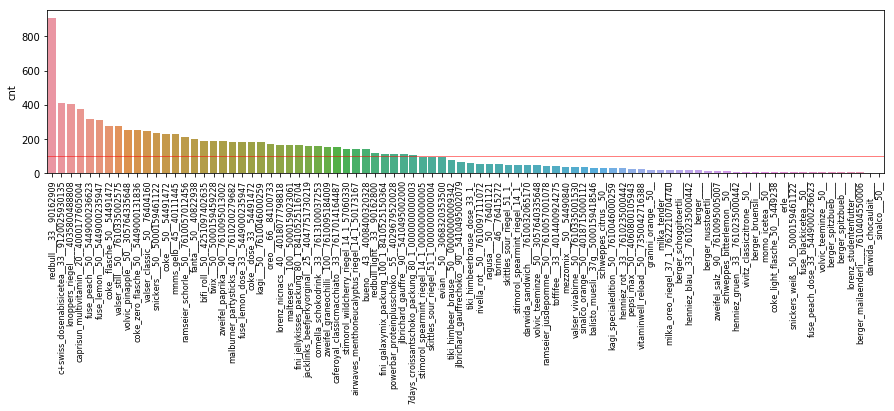

In [0]:
%matplotlib inline
from matplotlib import pyplot
import seaborn as sns

fig, ax = pyplot.subplots(figsize=(15,3))
data = df[df["cnt"] > 3].sort_values(by="cnt", ascending=False)
ax.axhline(y=100, color='r', linewidth=0.5)
g = sns.barplot(ax=ax, x=data.index.values, y=data["cnt"])
g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=8)

# Results Visuals

working on:  2019_5_22_21_48_48_scores_mobilenet_v2_075_128_5_100_0.01_0.003.csv
working on:  2019_5_22_21_48_48_scores_mobilenet_v2_075_128_5_70_0.01_0.003.csv
working on:  2019_5_22_21_48_48_scores_mobilenet_v2_075_128_5_30_0.01_0.003.csv
working on:  2019_5_22_21_48_48_scores_mobilenet_v2_075_128_5_10_0.01_0.003.csv
working on:  2019_5_22_21_48_48_scores_mobilenet_v2_075_128_5_7_0.01_0.003.csv
working on:  2019_5_22_21_48_48_scores_mobilenet_v2_075_128_5_3_0.01_0.003.csv
working on:  2019_5_22_21_48_48_scores_mobilenet_v2_075_128_5_1_0.01_0.003.csv
working on:  2019_5_22_21_48_48_scores_resnet_v2_50_5_100_0.01_0.003.csv
working on:  2019_5_22_21_48_48_scores_resnet_v2_50_5_70_0.01_0.003.csv
working on:  2019_5_22_21_48_48_scores_resnet_v2_50_5_30_0.01_0.003.csv
working on:  2019_5_22_21_48_48_scores_resnet_v2_50_5_10_0.01_0.003.csv
working on:  2019_5_22_21_48_48_scores_resnet_v2_50_5_7_0.01_0.003.csv
working on:  2019_5_22_21_48_48_scores_resnet_v2_50_5_3_0.01_0.003.csv
working on:

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Num Training Images per Product')]

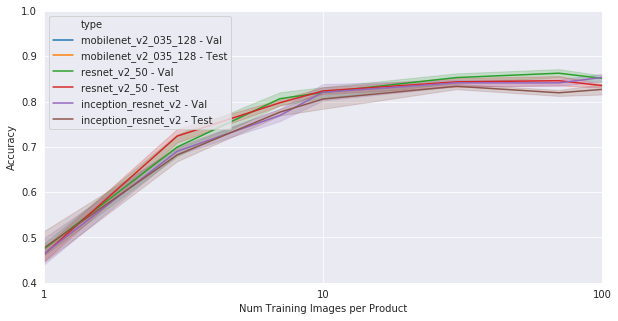

In [0]:
%matplotlib inline
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

param_dict = {"type": ["mobilenet_v2_035_128 - Val", "mobilenet_v2_035_128 - Test",
                       "resnet_v2_50 - Val", "resnet_v2_50 - Test",
                       "inception_resnet_v2 - Val", "inception_resnet_v2 - Test"], 
              "k_fold":[1, 3, 7, 10, 30, 70, 100],
              "kit": [0, 1, 2, 3, 4]}

param_grid = create_hyperparam_grid(param_dict)
index = ["type", "k_fold", "kit", "score"]

df = pd.DataFrame(param_grid, columns=index)
_dir = os.path.join(FLAGS_IC.scores_dir, "ExtraLayer")
for file in os.listdir(_dir):
  if file.endswith(".csv"):
    print("working on: ", file)
    filep = file.split(".csv")[0].split("_")
    score = pd.read_csv(os.path.join(_dir, file), sep=";")
    for kit in range(0,5):
      loc = ((df["type"] == "_".join(filep[7:-4]) + " - Test") &
             (df["k_fold"] == int(filep[-3])) & 
             (df["kit"] == kit))
      df.loc[loc, "score"] = score["('testing', {})".format(kit)].max(axis=0)
      
_dir = os.path.join(FLAGS_IC.scores_dir, "ExtraLayer")
for file in os.listdir(_dir):
  if file.endswith(".csv"):
    print("working on: ", file)
    filep = file.split(".csv")[0].split("_")
    score = pd.read_csv(os.path.join(_dir, file), sep=";")
    for kit in range(0,5):
      if "('validation', {})".format(kit) in score.keys():
        loc = ((df["type"] == "_".join(filep[7:-4]) + " - Val") &
               (df["k_fold"] == int(filep[-3])) &
               (df["kit"] == kit))
        df.loc[loc, "score"] = score["('validation', {})".format(kit)].max(axis=0)

#_dir = os.path.join(FLAGS_IC.scores_dir, "FineTuning", "hyperparam")
#for file in os.listdir(_dir):
#  if file.endswith(".csv"):
#    print("working on: ", file)
#    filep = file.split(".csv")[0].split("_")
#    score = pd.read_csv(os.path.join(_dir, file), sep=";")
#    for kit in range(0,5):
#      if "('validation', {})".format(kit) in score.keys():
#        loc = ((df["type"] == "FineTuning - Val") &
#               (df["tfhub_modules"] == "_".join(filep[7:-4])) &
#               (df["k_fold"] == int(filep[-3])) &
#               (df["regularization_rate"] == float(filep[-2].replace("-","."))) &
#               (df["learning_rate"] == float(filep[-1].replace("3e-05","0.00003").replace("-","."))) & 
#               (df["kit"] == kit))
#        df.loc[loc, "score"] = score["('validation', {})".format(kit)].max(axis=0)
      
#_dir = os.path.join(FLAGS_IC.scores_dir, "FineTuning")
#for file in os.listdir(_dir):
#  if file.endswith(".csv"):
#    print("working on: ", file)
#    filep = file.split(".csv")[0].split("_")
#    score = pd.read_csv(os.path.join(_dir, file), sep=";")
#    for kit in range(0,5):
#      loc = ((df["type"] == "FineTuning") &
#             (df["tfhub_modules"] == "_".join(filep[7:-4])) &
#             (df["k_fold"] == (int(filep[-4]),int(filep[-3]))) &
#             (df["regularization_rate"] == float(filep[-2].replace("-","."))) &
#             (df["learning_rate"] == float(filep[-1].replace("3e-05","0.00003").replace("-","."))) & 
#             (df["kit"] == kit))
      

print(df)
# Plot the responses for different events and regions
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10, 5))
ax.set(xscale="log")
g = sns.lineplot(x="k_fold", y="score",
             hue= "type", ax=ax,
             data=df)
plt.legend(loc='upper left')
g.set(xlim = (1,100))
xlabels = ['{}'.format(int(x)) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
g.set(ylim = (0.4,1.0))
ax.set(xlabel='Num Training Images per Product', ylabel='Accuracy')